# Tarea caso de estudio MLA
# PROBLEMA DE CLASIFICACIÓN Y PREDICCIÓN DE ÁRBOLES EN LA RESERVA ROOSEVELT: Utilización de datos cartográficos para predecir el árbol correspondiente

Profesor: Joaquin Villagra Pacheco

Alumno: Alejandro Méndez Miranda


# Introducción 

En la actualidad Chile cuenta con 106 parques forestales protegidos por el Sistema Nacional de Áreas
Silvestres Protegidas por el Estado (SNASPE). De estas 106 unidades 42 son Parques Nacionales, 46
son Reservas Nacionales y 18 Monumentos Nacionales .La conservación y protección de estas
regiones es de vital importancia para los distintos ecosistemas que se desarrollan, de importancia
para su flora y su fauna, además de generar un interés estético, histórico y científico.

Para solucionar el problema de obtener información de la población de
árboles en las reservas naturales sin generar una mayor intervención
humana se plantea la hipótesis de que conociendo cierta porción de la
población de árboles en la reserva natural se puede generar un modelo
para predecir, con altos niveles de exactitud (accuracy), el tipo de árbol
solo teniendo datos cartográficos a disposición.

Los datos cartográficos, aunque no sean de data bosques chilenos nos ayudará a estimar la posibilidad de la hipótesis, se obtienen  de la competencia pasada en kaggle: [Forest Cover Type Prediction](https://www.kaggle.com/c/forest-cover-type-prediction)

# 1.  Carga de librerías para el análisis

In [1]:
######## IMPORTACION DE LIBRERIAS############
import pandas as pd
import numpy as np
from natsort import natsorted

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost
from catboost import CatBoostClassifier, Pool

from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# 2. Preprocesamiento de datos

El preprocesamiento de la información se realizará para generar los distintos análisis gráficos de las variables. Para este dataset no es necesario realizar un preprocesamiento mayor debido a que esto genera problemas al realizar el modelo reduciendo la capacidad de entender la información. Además como se verá, es un dataset limpio que no contiene valores faltantes.

## 2.1. Carga del dataset

In [2]:
#El dataset viene correctamente especificado
data = pd.read_csv("covtype2.csv")
data

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


In [3]:
#Se obtiene la cantidad de filas y columnas
data.shape

(581012, 55)

In [4]:
#Se revisan los valores nulos o faltantes
data.isna().sum()

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


Se observa que la carga de la información fue exitosa, que no existen datos nulos y que el tipo de dato es int64, lo que es correcto para las variables a utilizar. A continuación se agregará información que está incluida en la explicación del dataset, pero que se modificó para poder agregarla como dataframe.

In [5]:
#Se crea un dataframe con la información de las zonas geológicas
climatic_zone = pd.read_csv("climatic_zone.txt")
climatic_zone["second_digit"] = [1,2,3,4,5,6,7,8]
climatic_zone

,first_digit,climatic_zone,geologic_zones,second_digit
0,1,ower montane,dryalluvium,1
1,2,lower montane,glacial,2
2,3,montane dry,shale,3
3,4,montane,sandstone,4
4,5,montane dry and montane,mixed sedimentary,5
5,6,montane and subalpine,unspecified in the USFS ELU Survey,6
6,7,subalpine,igneous and metamorphic,7
7,8,alpine,volcanic,8


In [6]:
#Se cargan las variables de estudio, que van de soil_1 al soil_40 y su respectivo código
code_usfs = pd.read_csv("code_usfs.txt")
code_usfs

,Study_Code,USFS
0,1,2702
1,2,2703
2,3,2704
3,4,2705
4,5,2706
5,6,2717
6,7,3501
7,8,3502
8,9,4201
9,10,4703


In [7]:
#Se desdumifican las variables soil y se genera una sola columna
soils = data.iloc[:,14:54].stack()
soils = pd.Categorical(soils[soils!=0].index.get_level_values(1))
soils.to_numpy()

array(['Soil_Type29', 'Soil_Type29', 'Soil_Type12', ..., 'Soil_Type2',
       'Soil_Type2', 'Soil_Type2'], dtype=object)

In [8]:
#Se crea un nuevo dataframe que contenga una columna con el tipo de suelo
#y se eliminan las variables binarias para Soil_Type
data_soil = data.iloc[:,:14]
data_soil["Type_Soil"] = soils.to_numpy()
data_soil

<ipython-input-8-13f56eafe158>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_soil["Type_Soil"] = soils.to_numpy()


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Type_Soil
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,Soil_Type29
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,Soil_Type29
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,Soil_Type12
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,Soil_Type30
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,Soil_Type29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,0,0,1,0,Soil_Type2
581008,2391,152,19,67,12,95,240,237,119,845,0,0,1,0,Soil_Type2
581009,2386,159,17,60,7,90,236,241,130,854,0,0,1,0,Soil_Type2
581010,2384,170,15,60,5,90,230,245,143,864,0,0,1,0,Soil_Type2


In [9]:
#Se realiza lo mismo que para tipo de suelo pero para las columnas Wilderness_Area
wildr = data_soil.iloc[:,-5:-1].stack()
wildr = pd.Categorical(wildr[wildr!=0].index.get_level_values(1))
data_soil = data_soil.drop(['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4'], axis=1)
data_soil['Wilderness_Area'] = wildr.to_numpy()

In [10]:
#Se recupera el primer y segundo dígico del código de 4 números de la columna USFS
code_usfs["first_digit"] = code_usfs["USFS"].map(lambda x: (x//100)//10)
code_usfs["second_digit"] = code_usfs["USFS"].map(lambda x: (x//100)%10)

#Se obtiene un dataframe donde tenga toda la información según el primer y segundo dígito
complete_codes = pd.merge(code_usfs, climatic_zone[["first_digit","climatic_zone"]])
complete_codes = pd.merge(complete_codes, climatic_zone[["second_digit","geologic_zones"]])
complete_codes["Study_Code"] = complete_codes["Study_Code"].map(lambda x: "Soil_Type{}".format(x))
complete_codes = complete_codes[["Study_Code","climatic_zone","geologic_zones"]]
complete_codes

,Study_Code,climatic_zone,geologic_zones
0,Soil_Type1,lower montane,igneous and metamorphic
1,Soil_Type2,lower montane,igneous and metamorphic
2,Soil_Type3,lower montane,igneous and metamorphic
3,Soil_Type4,lower montane,igneous and metamorphic
4,Soil_Type5,lower montane,igneous and metamorphic
5,Soil_Type6,lower montane,igneous and metamorphic
6,Soil_Type10,montane,igneous and metamorphic
7,Soil_Type11,montane,igneous and metamorphic
8,Soil_Type12,montane,igneous and metamorphic
9,Soil_Type13,montane,igneous and metamorphic


In [11]:
#Se crea la data completa para comenzar a trabajar en el análisis de variables
complete_data = pd.merge(complete_codes, data_soil, left_on='Study_Code', right_on='Type_Soil')
complete_data.drop(["Type_Soil"], inplace = True, axis = 1)
complete_data

,Study_Code,climatic_zone,geologic_zones,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area
0,Soil_Type1,lower montane,igneous and metamorphic,2173,50,28,124,100,212,219,167,64,552,Wilderness_Area4
1,Soil_Type1,lower montane,igneous and metamorphic,2161,113,32,458,142,524,254,188,34,390,Wilderness_Area4
2,Soil_Type1,lower montane,igneous and metamorphic,2110,54,25,342,150,390,225,177,71,466,Wilderness_Area4
3,Soil_Type1,lower montane,igneous and metamorphic,2206,65,33,210,144,201,229,155,31,361,Wilderness_Area4
4,Soil_Type1,lower montane,igneous and metamorphic,2132,73,27,365,172,408,239,179,53,488,Wilderness_Area4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,Soil_Type21,subalpine,dryalluvium,3278,239,10,30,8,1465,202,249,184,1339,Wilderness_Area3
581008,Soil_Type21,subalpine,dryalluvium,3283,238,9,30,-2,1448,204,248,181,1368,Wilderness_Area3
581009,Soil_Type21,subalpine,dryalluvium,3224,351,14,30,10,1380,194,215,159,618,Wilderness_Area3
581010,Soil_Type21,subalpine,dryalluvium,3226,349,15,0,0,1380,192,214,160,642,Wilderness_Area3


In [12]:
#Finalmente se crean las variables con nombres más reconocibles
X_data = complete_data.copy()
y_data = data.iloc[:,-1]

# 3. Análisis descriptivo de los datos

El análisis descriptivo de los datos se basará separará según el estudio de:
* Variable objetivo
* Variables categóricas
* Variables continuas

## 3.1. Análisis variable objetivo

Es bueno partir con un conteo de las variables categóricas

In [312]:
y_data.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

Para realizar el gráfico del conteo de las variables se crea una función que al darle el dataset, la categoría y datos del gráfico a realizar nos entrega el gráfico de barras del conteo.

In [72]:
#Se crea la función para realizar el gráfico del conteo

def count_variables(data,categoria, xlabel, ylabel, title, rotation = 0):
    #Se selecciona la data
    data = data
    #Se genera la paleta de colores, para que en todo momento los árboles correspondan a su color
    evenly_spaced_interval = np.linspace(0, 1, 9)
    colors = [cm.tab10(x) for x in evenly_spaced_interval]
    a_list = colors
    indices = [1,2,3,4,5,6,7]
    selected_elements = []
    for index in indices:
         selected_elements.append(a_list[index]) 
    #Se grafica. natsorted nos ordena las categorías cuando hay un texto formato xxxx111 (texto-numero)
    plt.figure(figsize = (10,7))
    ax=sns.countplot(natsorted(data[categoria]), palette = selected_elements)
    ax.set(xlabel=xlabel, ylabel=ylabel, 
           title = title)
    ax.set_xlabel(xlabel,fontsize=12);
    ax.set_ylabel(ylabel,fontsize=12)
    ax.set_title(title, fontsize = 15)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=rotation)
    plt.show()

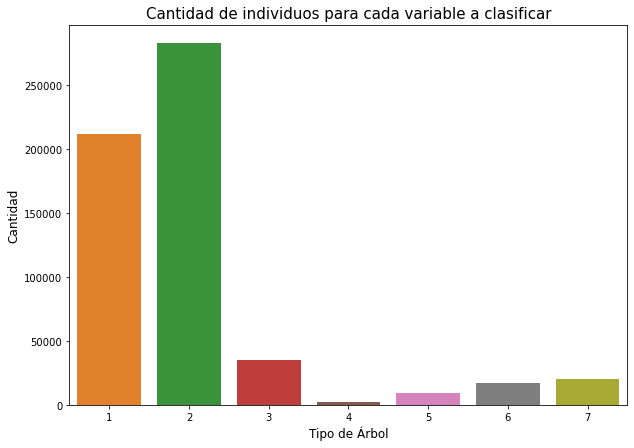

In [73]:
count_variables(data, "Cover_Type",'Tipo de Árbol', 'Cantidad', "Cantidad de individuos para cada variable a clasificar")

Del gráfico se observa lo desbalanceado de las variables objetivo. La categoría 1 y 2  concentra la mayor cantidad de datos. Las otras categorías se presentan en pequeñas cantidades, en especial la variable 4. Se deberá realizar el análisis de necesidad de balanceo de la informaicón.

## 3.2. Análisis de variables categóricas

Se cuenta con 4 variables categóricas: Tipo de suelo, zona geológica, zona climática y área silvestre.

### 3.2.1. Conteo de las variables

Se realizará el conteo para las variables categóricas anteriormente mencionadas

### 3.2.1.1. Tipo de suelo

In [311]:
X_data['Study_Code'].value_counts()

Soil_Type29    115247
Soil_Type23     57752
Soil_Type32     52519
Soil_Type33     45154
Soil_Type22     33373
Soil_Type10     32634
Soil_Type30     30170
Soil_Type12     29971
Soil_Type31     25666
Soil_Type24     21278
Soil_Type13     17431
Soil_Type38     15573
Soil_Type39     13806
Soil_Type11     12410
Soil_Type4      12396
Soil_Type20      9259
Soil_Type40      8750
Soil_Type2       7525
Soil_Type6       6575
Soil_Type3       4823
Soil_Type19      4021
Soil_Type17      3422
Soil_Type1       3031
Soil_Type16      2845
Soil_Type26      2589
Soil_Type18      1899
Soil_Type35      1891
Soil_Type34      1611
Soil_Type5       1597
Soil_Type9       1147
Soil_Type27      1086
Soil_Type28       946
Soil_Type21       838
Soil_Type14       599
Soil_Type25       474
Soil_Type37       298
Soil_Type8        179
Soil_Type36       119
Soil_Type7        105
Soil_Type15         3
Name: Study_Code, dtype: int64

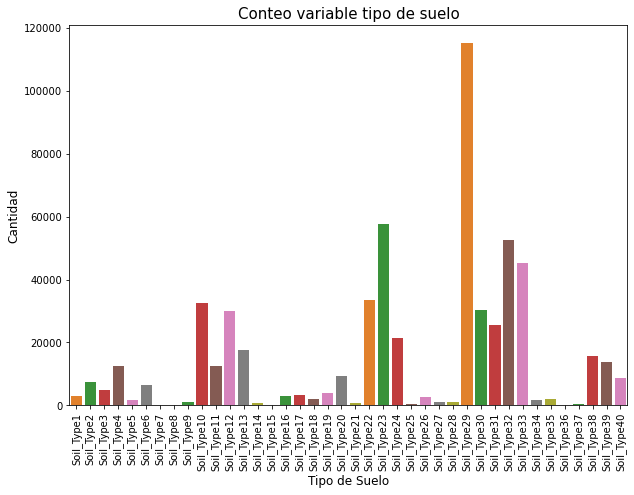

In [182]:
count_variables(X_data, "Study_Code",'Tipo de Suelo', 'Cantidad', "Conteo variable tipo de suelo", rotation = 90)

### 3.2.1.2. Zona climática

In [313]:
X_data['climatic_zone'].value_counts()

subalpine                  401983
montane                     93593
alpine                      40437
lower montane               35947
montane and subalpine        8166
montane dry and montane       602
montane dry                   284
Name: climatic_zone, dtype: int64

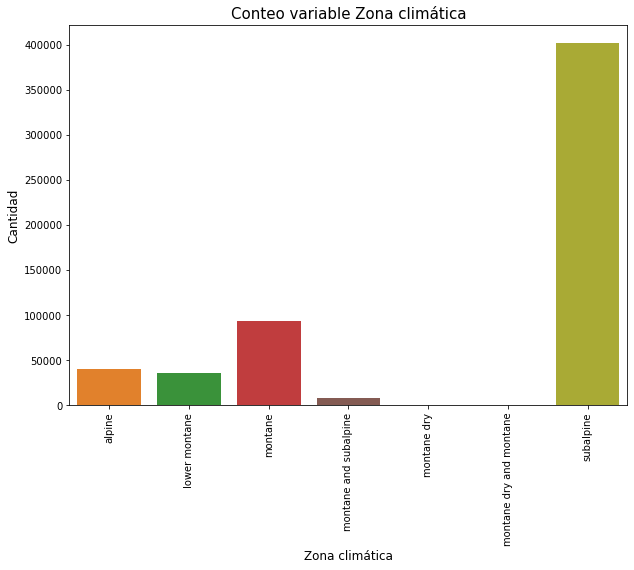

In [183]:
count_variables(X_data, "climatic_zone",'Zona climática', 'Cantidad', "Conteo variable Zona climática", rotation = 90)

### 3.2.1.3. Zona geológica

In [314]:
X_data['geologic_zones'].value_counts()

igneous and metamorphic    467469
glacial                     92272
dryalluvium                 20987
mixed sedimentary             284
Name: geologic_zones, dtype: int64

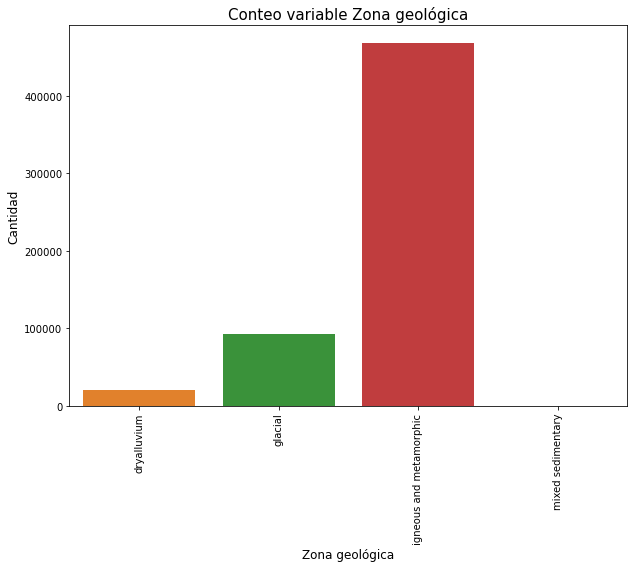

In [184]:
count_variables(X_data, "geologic_zones",'Zona geológica', 'Cantidad', "Conteo variable Zona geológica", rotation = 90)

### 3.2.1.4. Área silvestre

In [315]:
X_data['Wilderness_Area'].value_counts()

Wilderness_Area1    260796
Wilderness_Area3    253364
Wilderness_Area4     36968
Wilderness_Area2     29884
Name: Wilderness_Area, dtype: int64

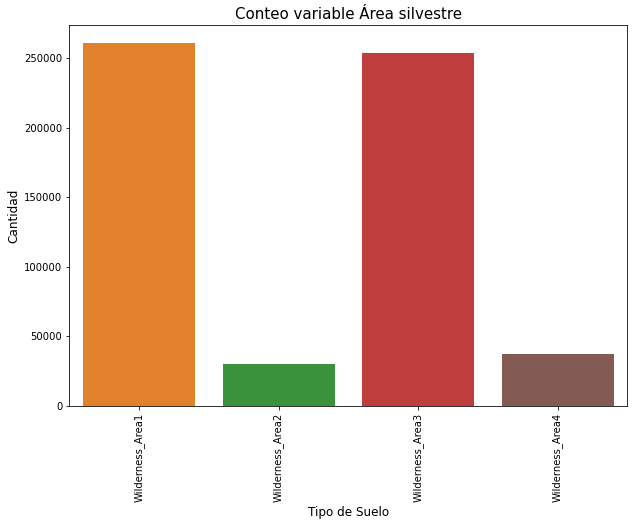

In [185]:
count_variables(X_data, "Wilderness_Area",'Tipo de Suelo', 'Cantidad', "Conteo variable Área silvestre", rotation = 90)

Si revisamos el conteo de las variables categóricas nos entontramos:
* Desbalanceo en el tipo de suelo, categorías como  el tipo de suelo 29 se encuentra por mucho sobre las otras variables, mientras que categorías tipo de suelo 7 y 8 (entre otras) están casi ausentes.
* Desbalanceo en las zonas climáticas, la categoría subalpino está por mucho sobre las otras, mientras que la zona de montaña seca casi no está presente, como es de esperar por lo seco de la zona el crecimiento de árboles es muy dificil.
* Si revisamos la zona geológica, nuevamente nos encontramos desbalanceo, siendo la zona ignea-metamórfica la más presente sobre las otras categorías, por otro lado la categoría sedimentario mixto casi no está presente, nuevamente esperable debido a que la zona sedimentaria es material muy fino (como arena)
* Finalmente si revisamos las zonas silvestres nos encontramos mayor presencia en la zona 1-3 por sobre la 2-4. Un estudio posterior en este trabajo nos ayudará a entender la razón.

### 3.2.2. Conteo de variables categóricas considerando la variable objetivo

Al igual que antes, se crea una función que nos entregue el conteo, pero ahora separando según la variable objetivo. Además, se toma en cuenta tema estéticos debido a la gran cantidad de categorías que se podría generar para ciertas variables (como tipo de suelo).

In [186]:
def categoricalplot(cat, files = 2, columns = 2, impar = False, 
                    manycolors = 9, filtro = False, down = 0, up = 2, y_data = y_data):
    
    """
    Se crea esta función debido a que es complejo ver todas las cageorías en un solo gráfico, la mejor
    solución fue separarlas y graficarlas a parte cada una.
    """
    
    #Se creó un filtro exclusivo para la variable tipo de suelo al tener tantas categorías
    if filtro == True:
        czon = natsorted(X_data.Study_Code.unique())[down:up]
    else:   
        czon = X_data[cat].unique()
    
    #Nuevamente se utiliza la paleta de colores
    evenly_spaced_interval = np.linspace(0, 1, manycolors)
    colors = [cm.tab10(x) for x in evenly_spaced_interval]


    #Se grafica mediante un bucle for según la cantidad que dimos en los parámetros up y down
    fig, ax = plt.subplots(files,columns, figsize = (15,10))
    plt.subplots_adjust(hspace  =0.5, wspace = 0.5)
    for i, ax_i in enumerate(ax.flat):  
        a_list = colors
        indices = sorted(np.unique(list(y_data[X_data[cat] == czon[i]])))
        selected_elements = []
        #Acá se filtra según la categoría para graficar uno a uno
        for index in indices:
            selected_elements.append(a_list[index])
        pd.crosstab(X_data[X_data[cat] == czon[i]][cat].values,y_data[X_data[cat] == czon[i]]).plot(color = selected_elements, kind = "bar", ax = ax_i)
        ax_i.xaxis.set_visible(False)
        ax_i.set_xticks([])
        ax_i.set_title(czon[i])
        #Siempre genera un error cuando el último gráfico queda vacío, por ejemplo, si usamos
        #una malla 2x2 y solo queremos graficar 3 plots, sobra uno y lanza un error o queda un marco
        #vacío. Si se elimina de esta manera se soluciona el problema, con fig.delaxes()
        if impar == True:
            if i == files*columns -2:
                fig.delaxes(ax[files -1, columns -1])
                break
        
    plt.show()

### 3.2.2.1. Tipo de suelo

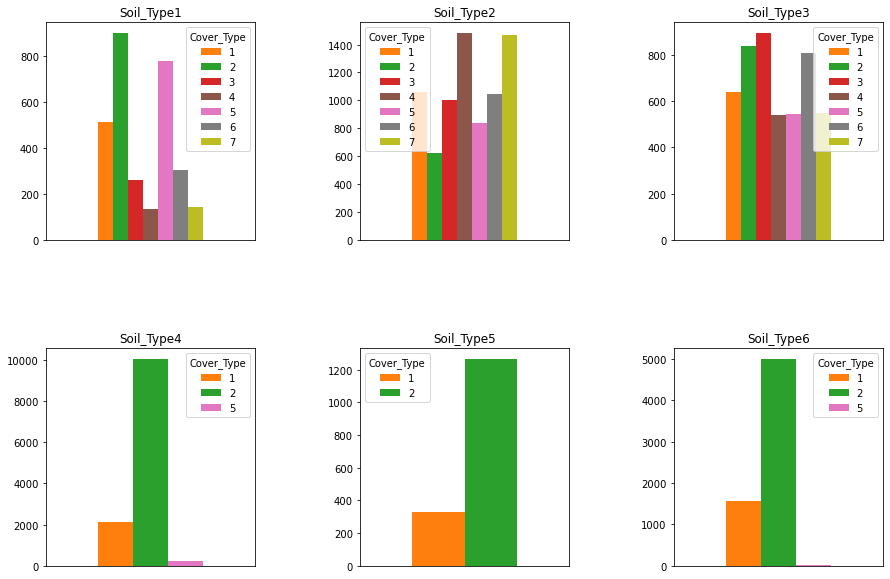

In [187]:
categoricalplot("Study_Code", 2,3, filtro = True, down = 0, up = 6)

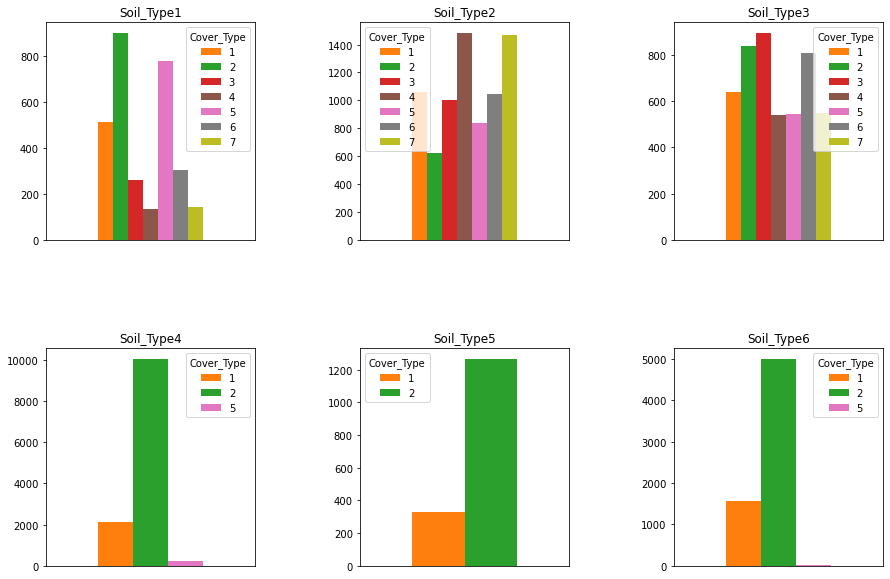

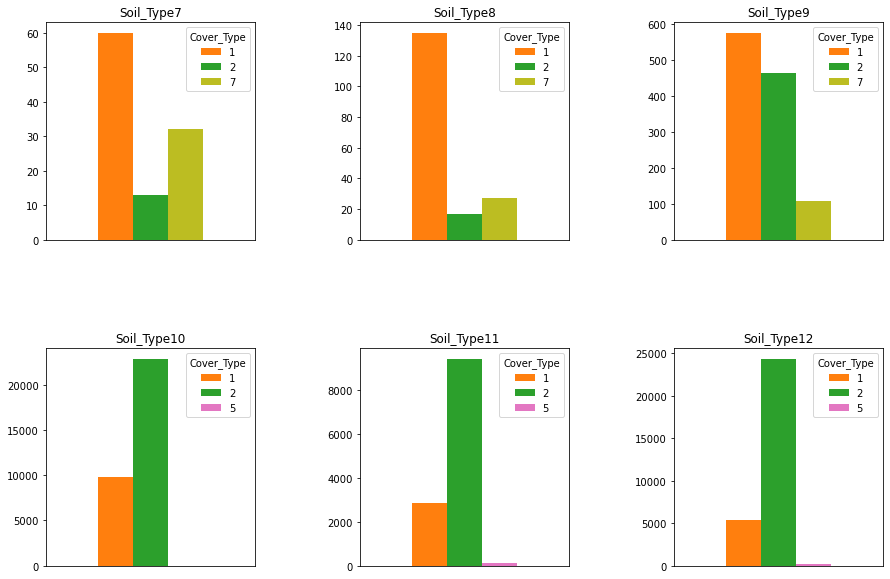

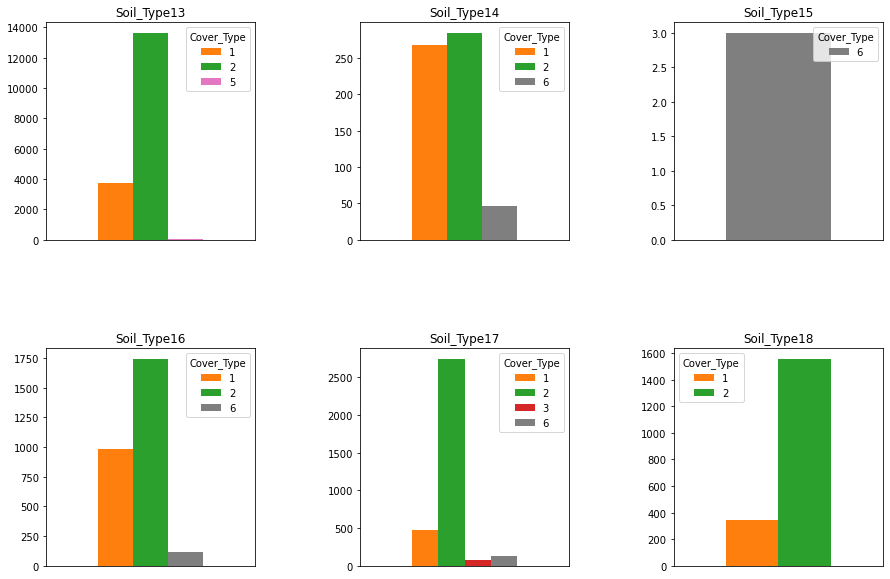

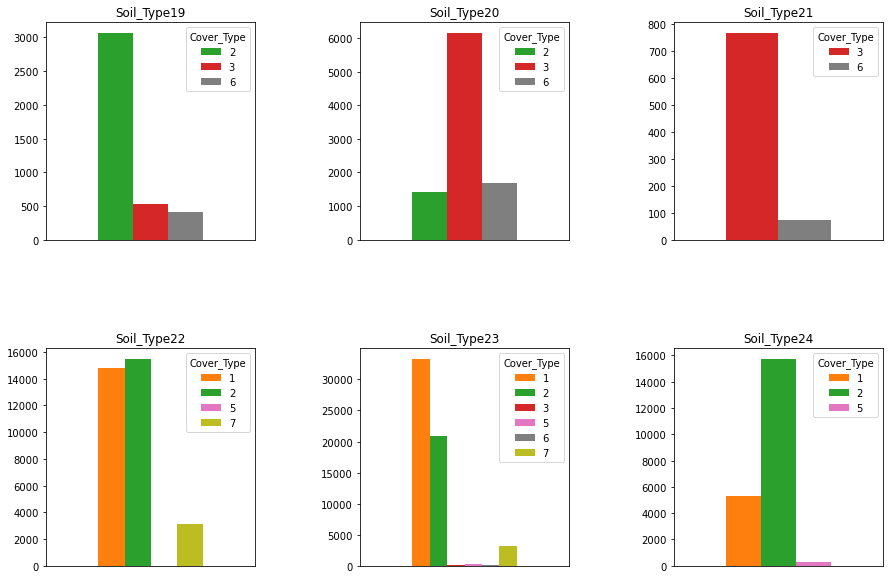

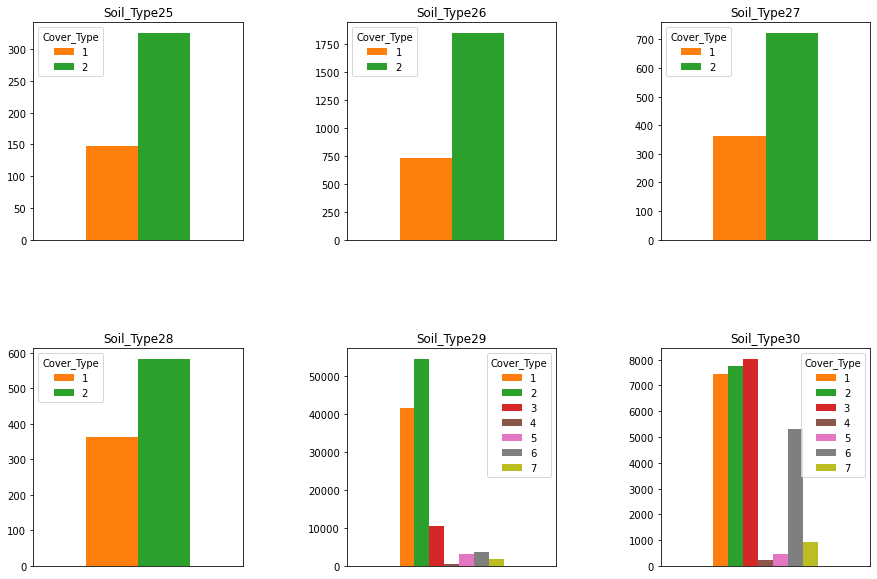

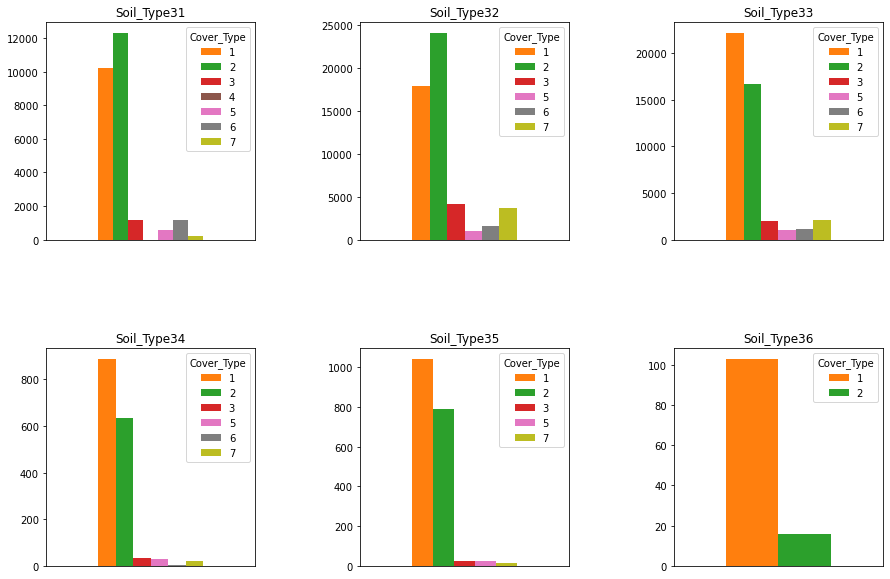

In [188]:
for i in range(0,6):
    categoricalplot("Study_Code", 2,3, filtro = True, down = i*6, up = i*6+6)


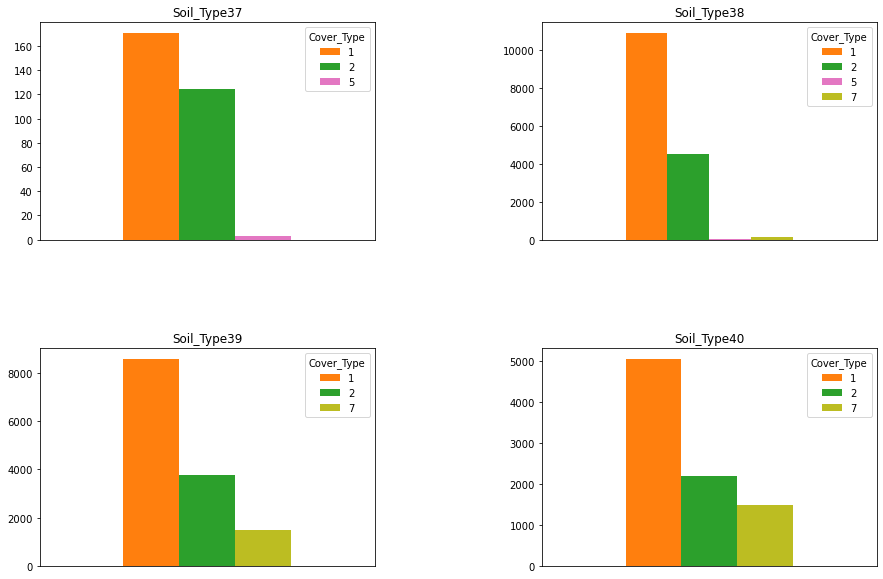

In [189]:
categoricalplot("Study_Code", 2,2, filtro = True, down = 36, up = 40)

### 3.2.2.2. Zona climática

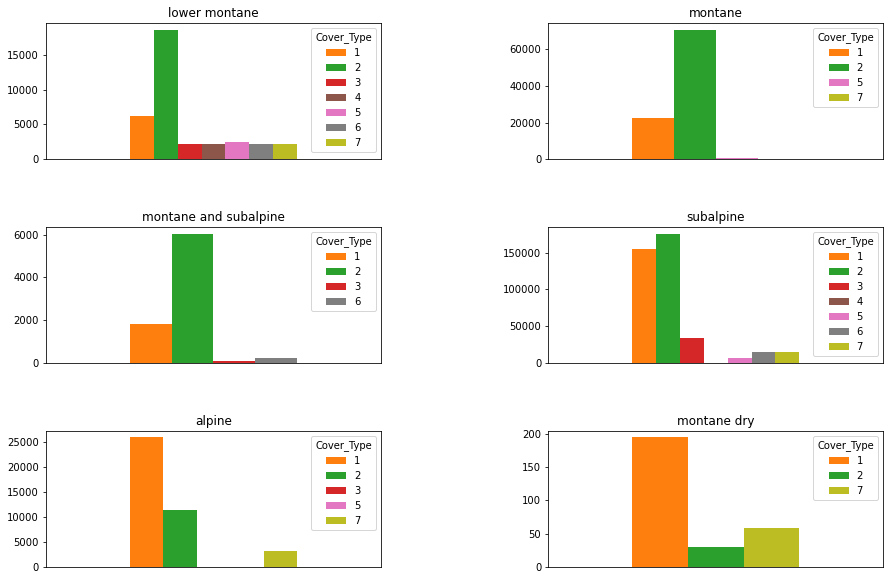

In [190]:
categoricalplot("climatic_zone", 3,2, False)

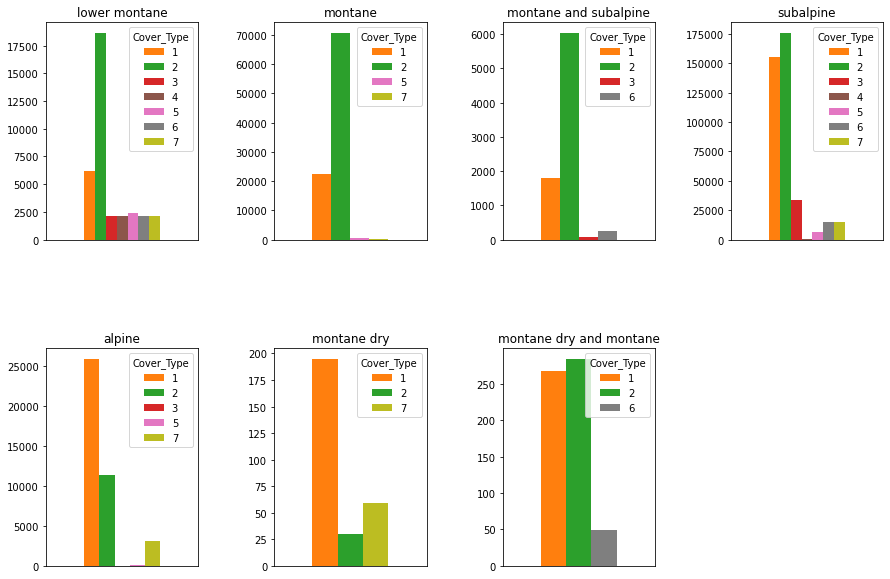

In [191]:
categoricalplot("climatic_zone", 2,4, impar = True)

### 3.2.2.3. Zona geológica

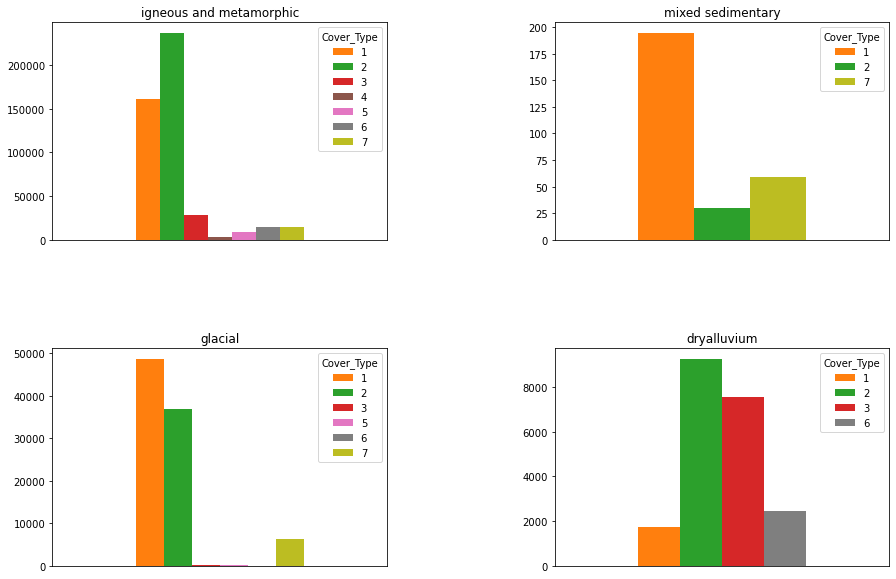

In [192]:
categoricalplot("geologic_zones", 2,2, False)

### 3.2.2.4. Área Silvestre

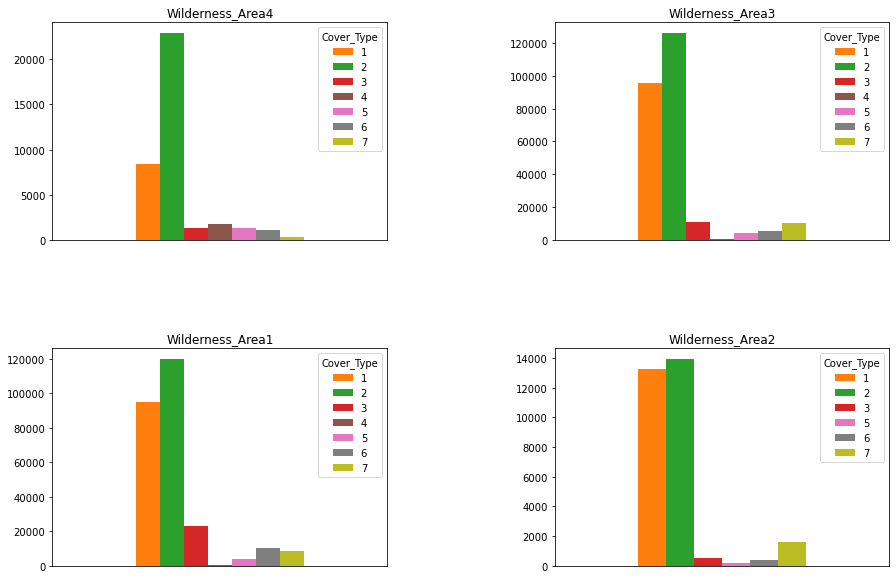

In [193]:
categoricalplot("Wilderness_Area", 2,2)

Analizando el conteo de las variables categóricas según la variable objetivo nos encontramos que:

* Aunque la presencia de árboles 1 y 2 es alta en general en todos los tipos de suelo, existen algunos donde solo hay presencia de ciertos árboles, como el tipo de suelo 15 que tiene presencia absoluta del árbol 6 y el tipo de suelo 21 que tiene presencia del árbol 3 y 6. Lo cual nos ayudaría mucho para realizar las predicciones.
* Si se toma la zona climática,geológica y área silvestre nos damos cuenta que los árboles 1 y 2 siempre opacan la presencia de los otros árboles, lo cual podría influir negativamente en el análisis.


### 3.2.3. Análisis de área silvestre vs otras categorías

Para este análisis no se considerará el tipo de suelo, ya que se puede considerar la zona geológica y climática que dependen del tipo de suelo. Además se limitará el rango del gráfico en el eje "y" a 60000, sobre esa cantidad ya se considerará suficientemente grande para saber su importancia y no  influirá tan negativamente a la visualización de las otras categorías.

In [194]:
def catvscat(x,hue,data, xlabel, ylabel, title,rotation):
    plt.figure(figsize = (10,7))
    ax = sns.countplot(x = x, hue = hue, data = data.sort_values(by=[x]))
    ax.set_xlabel(xlabel,fontsize=12);
    ax.set_ylabel(ylabel,fontsize=12)
    ax.set_title(title, fontsize = 15)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=rotation)
    ax.set_ylim(0,60000)
    plt.show()

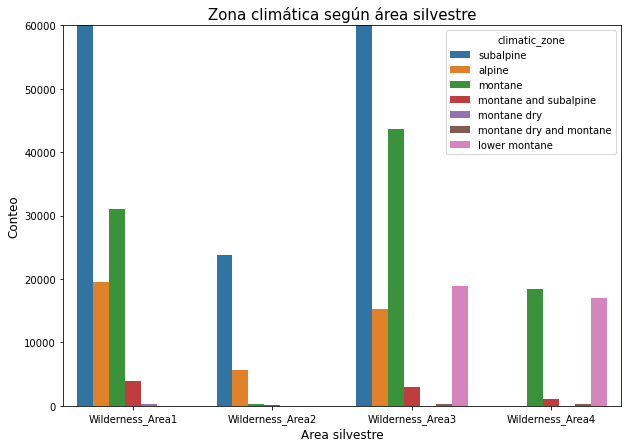

In [195]:
catvscat(x="Wilderness_Area",hue="climatic_zone",data =X_data, 
         xlabel = "Area silvestre", ylabel = "Conteo", 
         title = "Zona climática según área silvestre" ,rotation = 0)

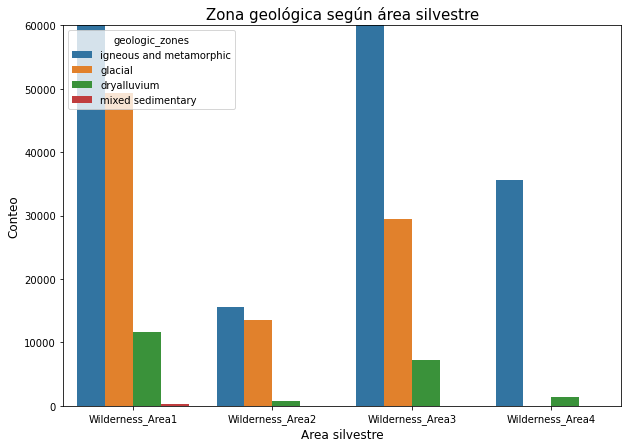

In [196]:
catvscat(x="Wilderness_Area",hue="geologic_zones",data =X_data, 
         xlabel = "Area silvestre", ylabel = "Conteo", 
         title = "Zona geológica según área silvestre" ,rotation = 0)

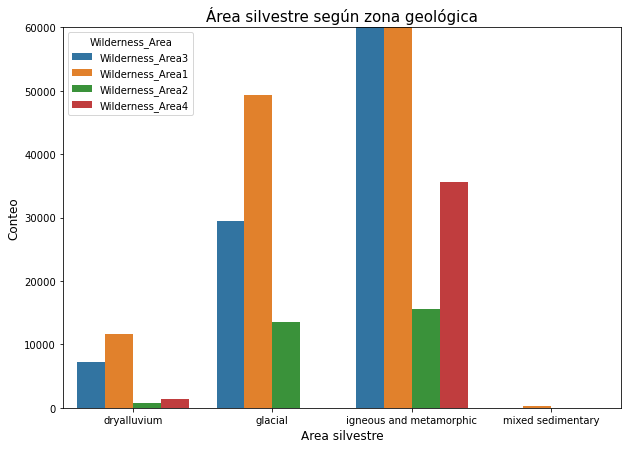

In [197]:
catvscat(hue="Wilderness_Area",x="geologic_zones",data =X_data, 
         xlabel = "Area silvestre", ylabel = "Conteo", 
         title = "Área silvestre según zona geológica" ,rotation = 0)

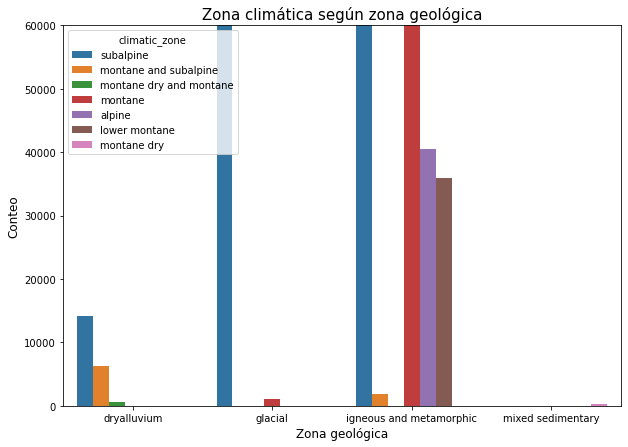

In [198]:
catvscat(hue="climatic_zone",x="geologic_zones",data =X_data, 
         xlabel = "Zona geológica", ylabel = "Conteo", 
         title = "Zona climática según zona geológica" ,rotation = 0)

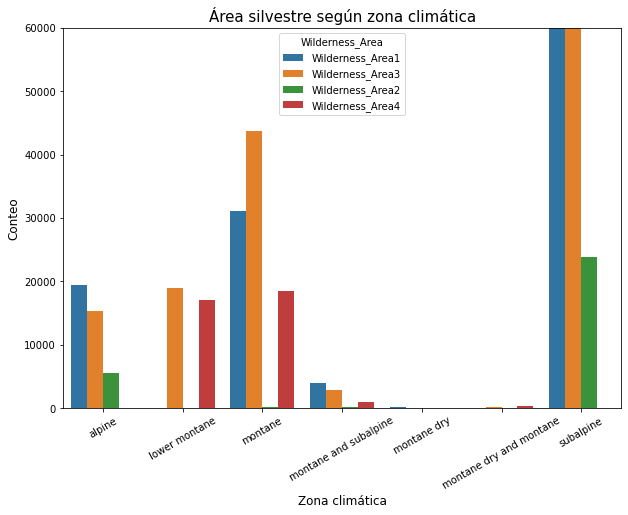

In [199]:
catvscat(hue="Wilderness_Area",x="climatic_zone",data =X_data, 
         xlabel = "Zona climática", ylabel = "Conteo", 
         title = "Área silvestre según zona climática" ,rotation = 30)

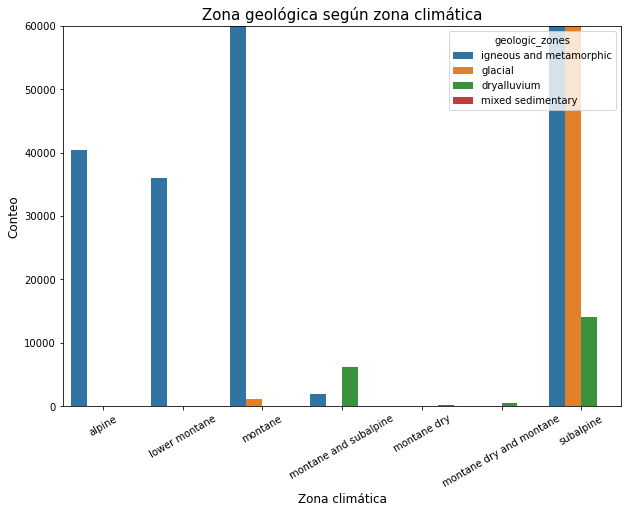

In [200]:
catvscat(hue="geologic_zones",x="climatic_zone",data =X_data, 
         xlabel = "Zona climática", ylabel = "Conteo", 
         title = "Zona geológica según zona climática" ,rotation = 30)

Al realizar el conteo de las variables categóricas contra las otras variables categóricas que se quieren estudiar se obtiene que:

* El area silvestre 1 y 3 contiene la menor cantidad de zonas climática subalpina (la que contentraba la mayor cantidad de árboles) y una menor cantidad de zona geológica ignea-metamórfica, que al parecer son las zonas más fértiles.

* Finalmente la zona climática subaplina, alpina, montaña baja y montaña son las que contentran en mayor cantidad la zona geológica ignea-metamórfica.

## 3.3. Análisis variables continuas

In [317]:
columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points']

X_data[columns].describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000


Para el análisis de variables continuas se realizarán los siguientes gráficos considerando la separación según la variable objetivo (tipo de árbol):

* Boxplots
* Violinplots
* Scatterplots
* Histogramas

### 3.3.1. Boxplots de variables continuas

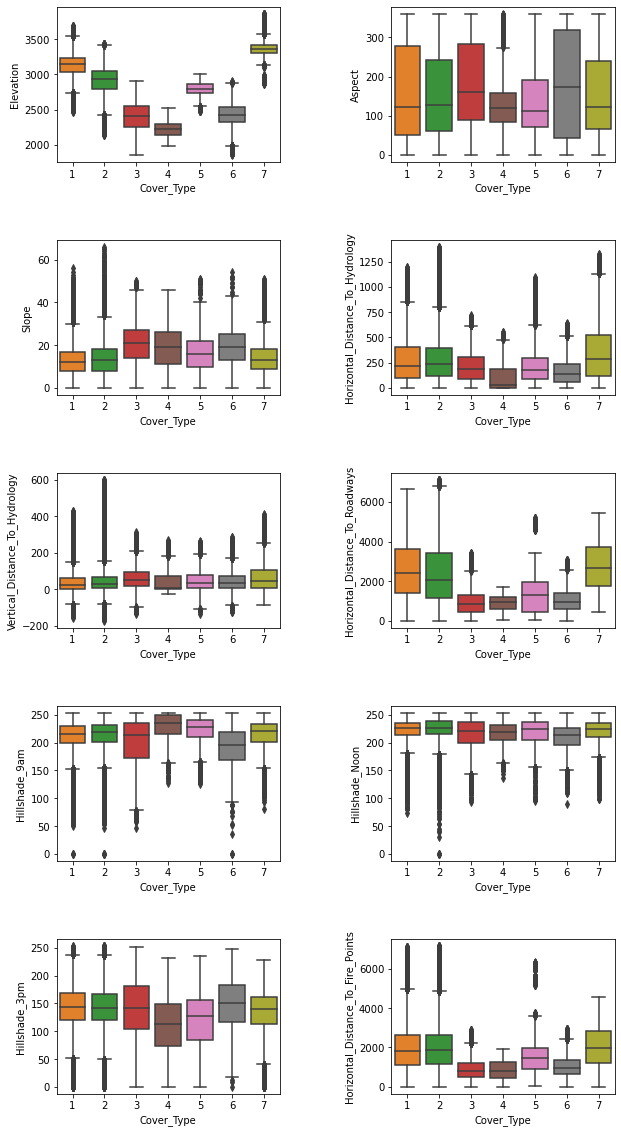

In [202]:
evenly_spaced_interval = np.linspace(0, 1, 9)
colors = [cm.tab10(x) for x in evenly_spaced_interval]
fig, ax = plt.subplots(5,2, figsize = (10,20))
plt.subplots_adjust(hspace  =0.5, wspace = 0.5)
for i, ax_i in enumerate(ax.flat):
    a_list = colors
    indices = [1,2,3,4,5,6,7]
    selected_elements = []
    for index in indices:
        selected_elements.append(a_list[index])
    g=sns.boxplot(y=data[columns[i]], x = data["Cover_Type"], ax = ax_i, palette = selected_elements)
    

Respecto al análisis de boxplots encontramos en general una distribución muy parecida para los distintos tipos de árboles. Las variables que al parecer están un poco más dispersas según el tipo de árbol son elevación, aspecto y distancia horizontal a caminos. En segunda instancia podría considerarse la distancia a puntos de fuego y la sombra que generan a las 9am y 3pm. Los demás pareciera tener distribuciones muy parecidas entre los cuartiles 1 y 3.

### 3.3.2. Violinplots de variables continuas

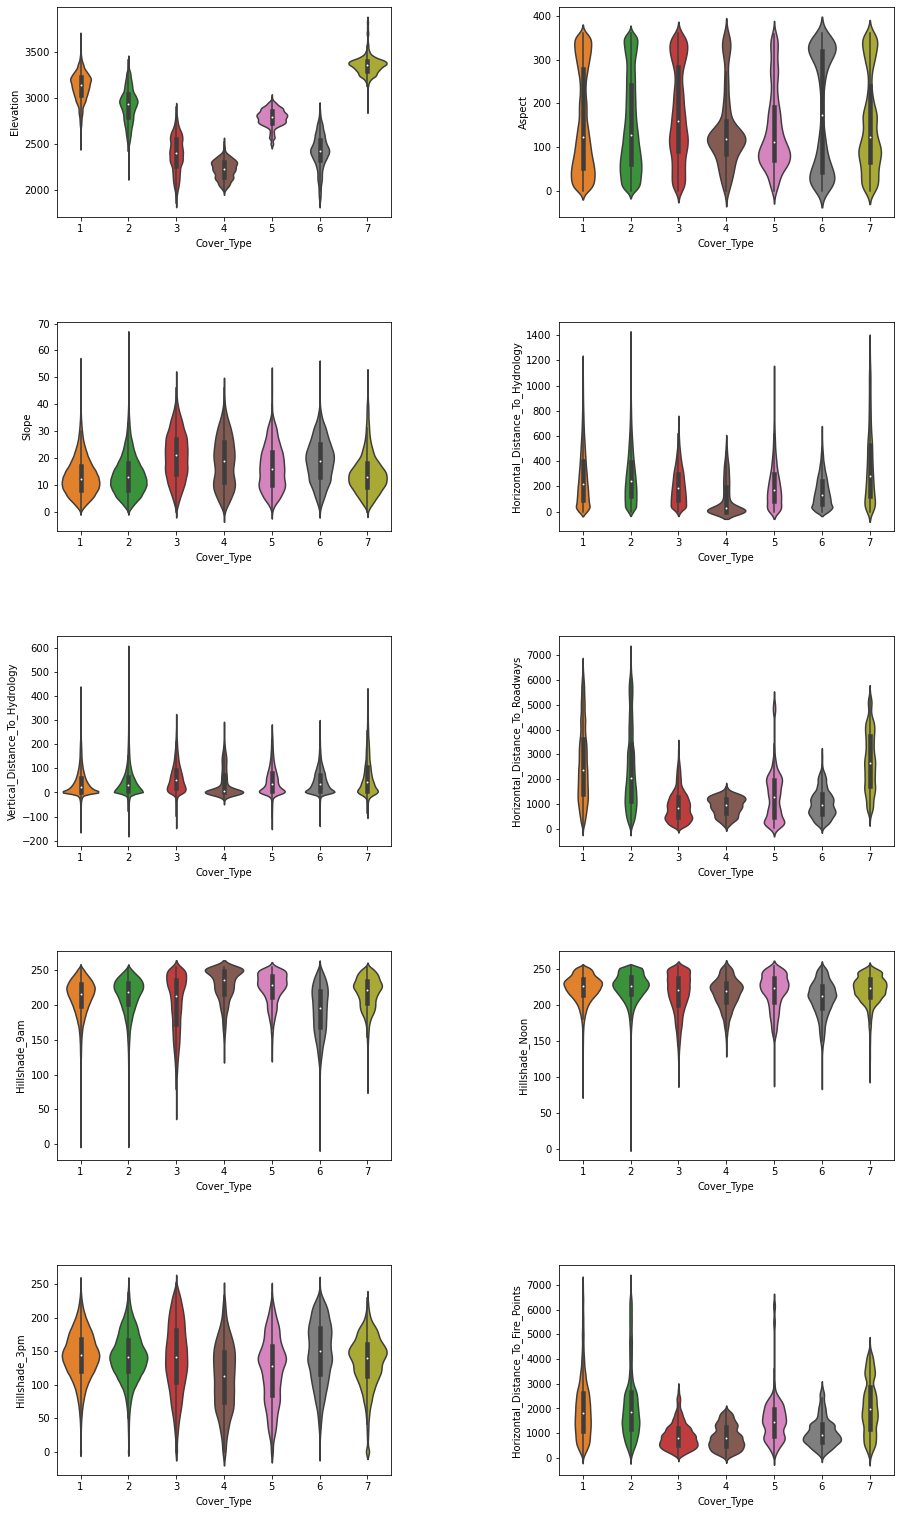

In [203]:
evenly_spaced_interval = np.linspace(0, 1, 9)
colors = [cm.tab10(x) for x in evenly_spaced_interval]
fig, ax = plt.subplots(5,2, figsize = (15,27))
plt.subplots_adjust(hspace  =0.5, wspace = 0.5)
for i, ax_i in enumerate(ax.flat):
    a_list = colors
    indices = [1,2,3,4,5,6,7]
    selected_elements = []
    for index in indices:
        selected_elements.append(a_list[index])
    g=sns.violinplot(y=data[columns[i]], x = data["Cover_Type"], ax = ax_i, palette = selected_elements)

A diferencia de ver los boxplot, los violinplots nos muestra una distribución distinta para cada tipo de árbol, aunque se pueden parecer existen leves diferencia en la distribución de árboles para cada variable continua. Esto se analizará mejor en los histogramas para cada variable.

### 3.3.3. Histogramas

In [281]:
evenly_spaced_interval = np.linspace(0, 1, 9)
colors = [cm.tab10(x) for x in evenly_spaced_interval]
a_list = colors
indices = [1,2,3,4,5,6,7]
selected_elements = []
for index in indices:
    selected_elements.append(a_list[index])

def histplot(column):
    plt.figure(figsize = (100,100))
    g = sns.FacetGrid(data[[column,"Cover_Type"]], hue="Cover_Type", height = 10, palette = selected_elements)
    g = g.map(sns.distplot, column,  hist=False, rug=False)
    g.fig.suptitle('{}'.format(column), fontsize = 30)
    plt.legend(fontsize='x-large', title_fontsize='40')

<Figure size 7200x7200 with 0 Axes>

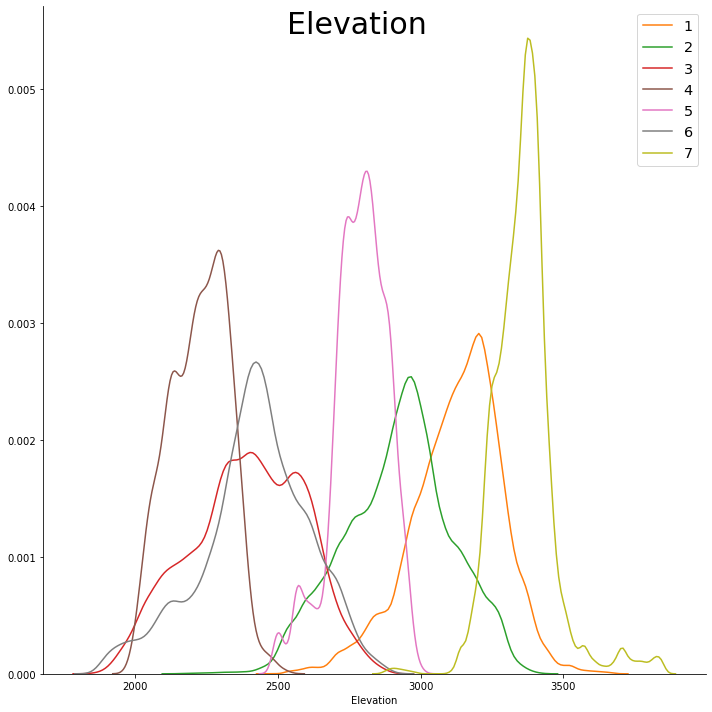

<Figure size 7200x7200 with 0 Axes>

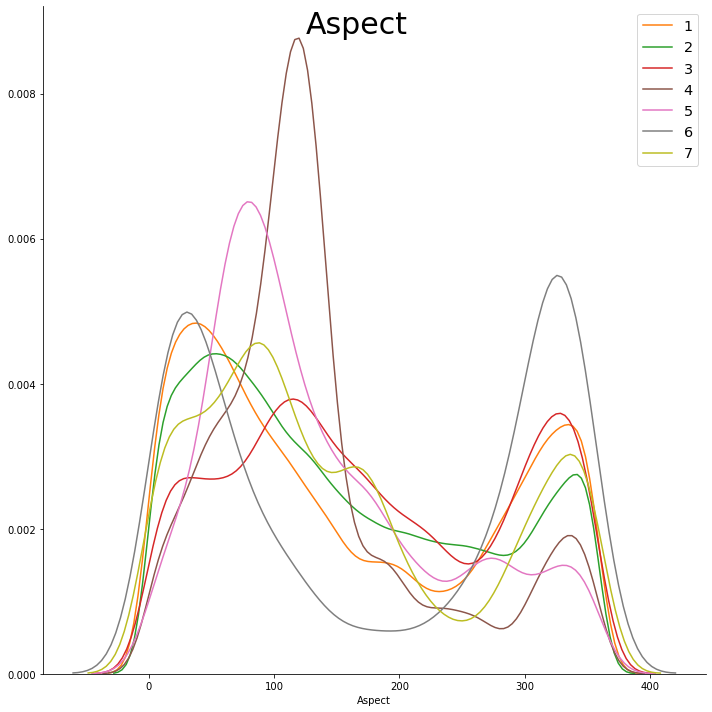

<Figure size 7200x7200 with 0 Axes>

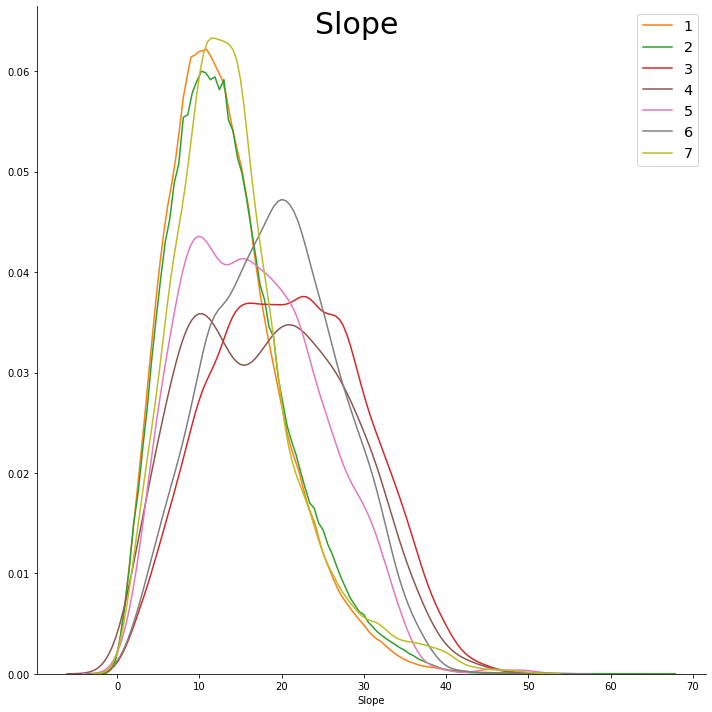

<Figure size 7200x7200 with 0 Axes>

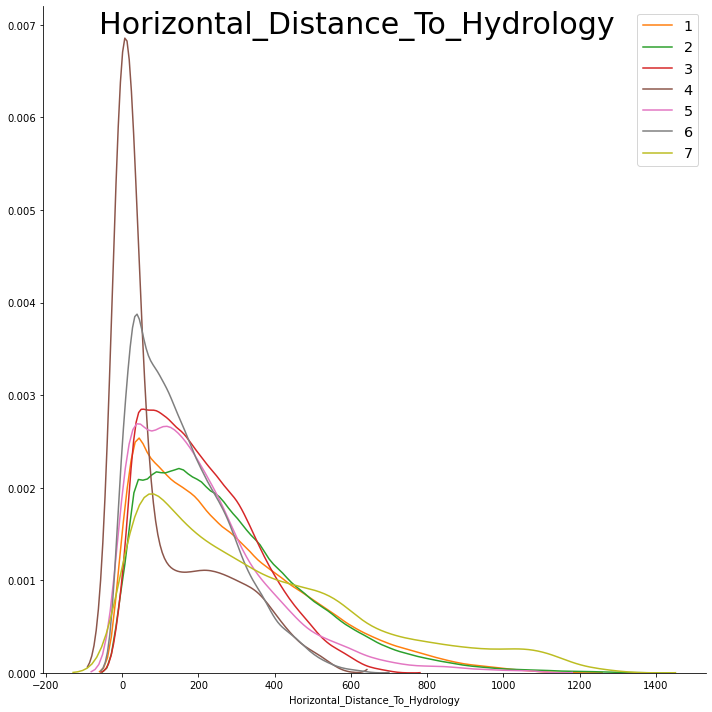

<Figure size 7200x7200 with 0 Axes>

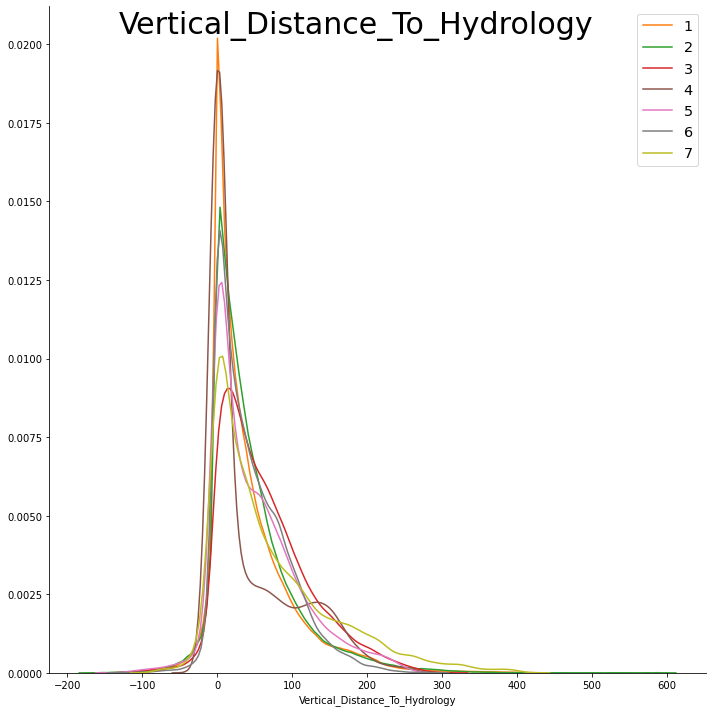

<Figure size 7200x7200 with 0 Axes>

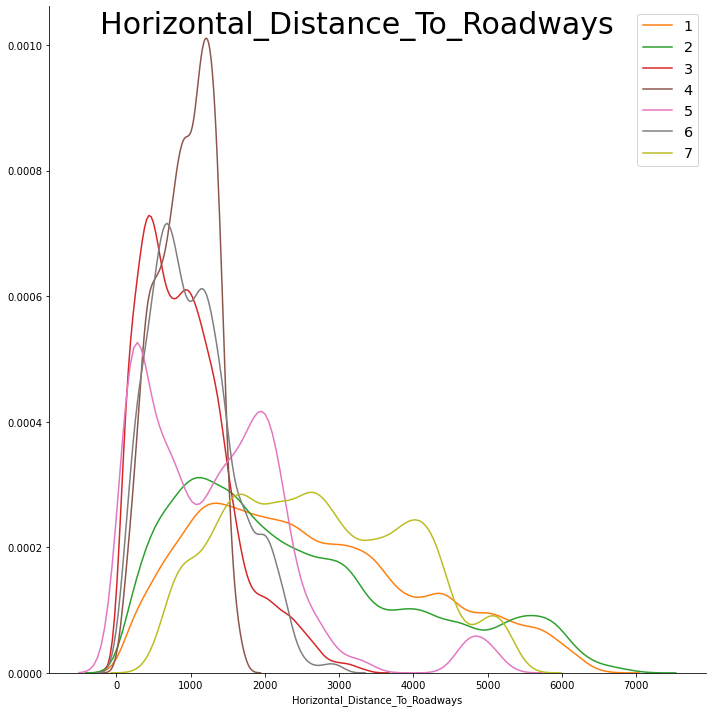

<Figure size 7200x7200 with 0 Axes>

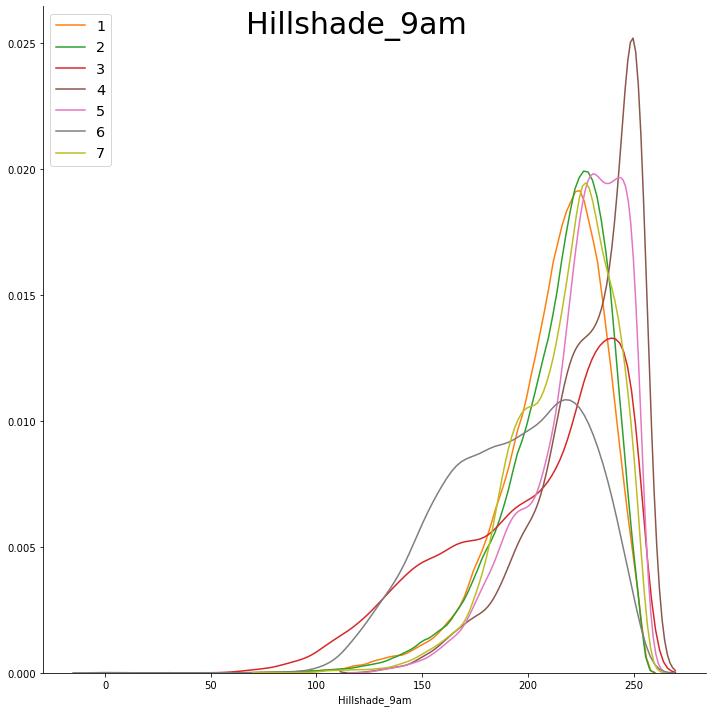

<Figure size 7200x7200 with 0 Axes>

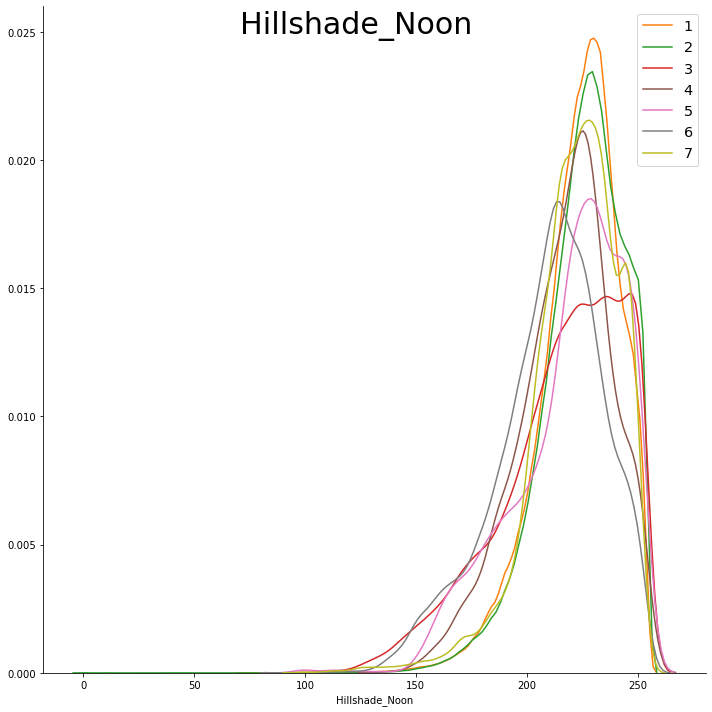

<Figure size 7200x7200 with 0 Axes>

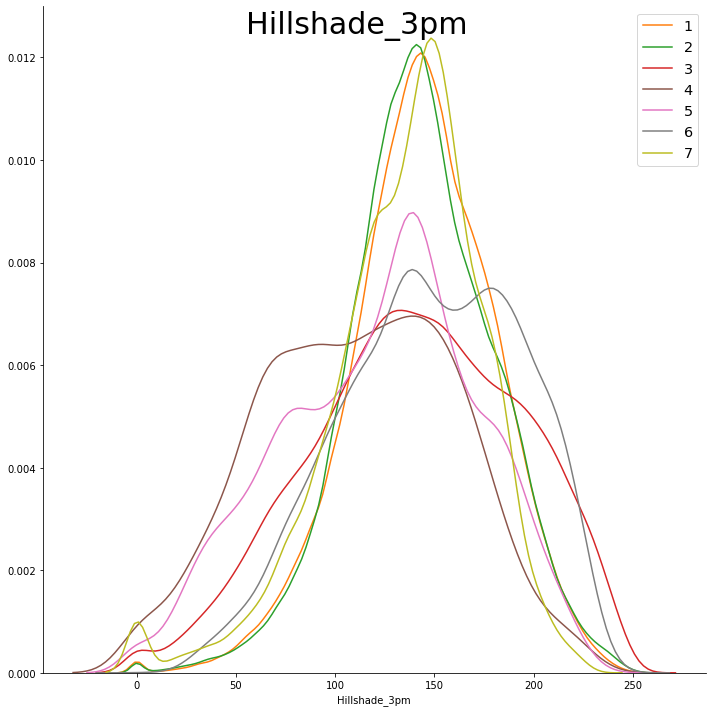

<Figure size 7200x7200 with 0 Axes>

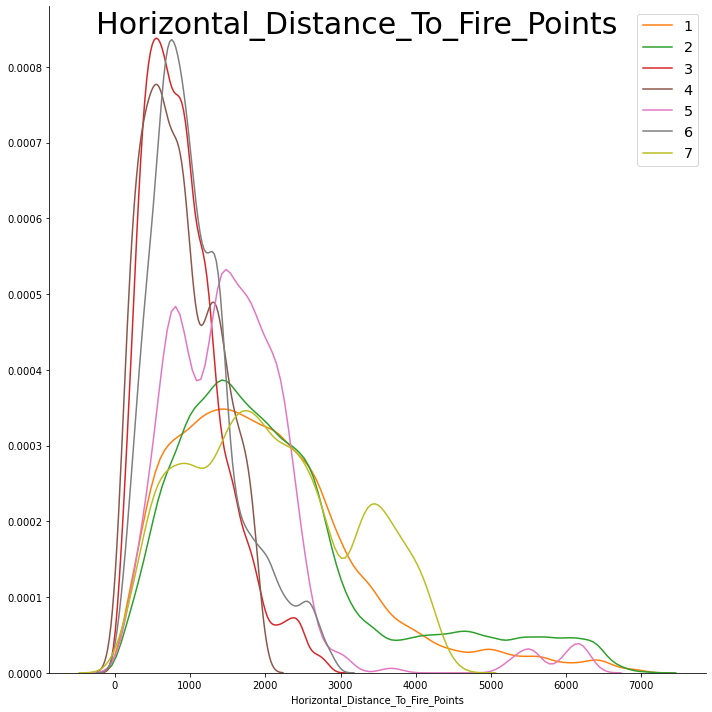

In [282]:
for i in columns:
    histplot(i)
    plt.show()

Al analizar los histogramas de distribución para las variables continuas nos encontramos con algunas distribuciones parecida para los distintos árboles, como distancia vertical a cuerpos de agua o inclinación (slope), pero existen otras donde la distribución es muy desigual como elevación; además existen ciertos árboles que destacan en ciertas distribuciones, como el árbol 6 en la variable distancia a caminos y el árbol 4 en aspecto.

# 4. Análisis de variables

Para realizar este análisis es necesario dumificar las variables.

## 4.1 Dumificación de variables

In [284]:
a = pd.get_dummies(X_data['climatic_zone'],drop_first = False)
b = pd.get_dummies(X_data['geologic_zones'],drop_first = False)
c = pd.get_dummies(X_data['Wilderness_Area'],drop_first = False)
d = pd.get_dummies(X_data['Study_Code'],drop_first = False)

dummies = [X_data, a, b, c,d]
X_datad = pd.concat(dummies, axis = 1)
#Se eliminan las variables en forma no dummificada
X_datad = X_datad.drop(columns = ['climatic_zone', 'geologic_zones', 'Wilderness_Area', 'Study_Code'])
X_datad.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type4,Soil_Type40,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9
0,2173,50,28,124,100,212,219,167,64,552,...,0,0,0,0,0,0,0,0,0,0
1,2161,113,32,458,142,524,254,188,34,390,...,0,0,0,0,0,0,0,0,0,0
2,2110,54,25,342,150,390,225,177,71,466,...,0,0,0,0,0,0,0,0,0,0
3,2206,65,33,210,144,201,229,155,31,361,...,0,0,0,0,0,0,0,0,0,0
4,2132,73,27,365,172,408,239,179,53,488,...,0,0,0,0,0,0,0,0,0,0


Para este análisis se utilizarán dos metodologías, además se considerará la data con todas las variables creadas y la data con las variables originales. Las metodologías son:

* Univariate Selection
* Feature Importance Model

### 4.2.1. Univariate Selection considerando todas las variables creadas

In [306]:
test = SelectKBest(score_func=f_classif, k=4)
fit = test.fit(X_datad, y_data)
set_printoptions(precision=3)
scor_kbest = fit.scores_
features = fit.transform(X_datad)

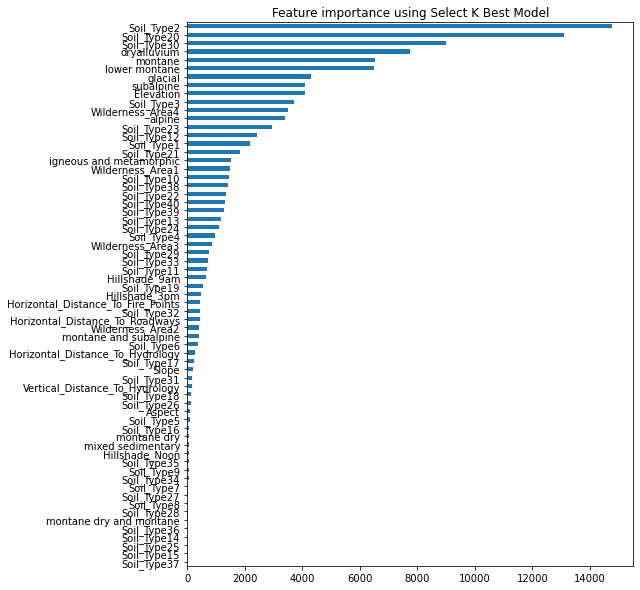

In [307]:
coef = pd.Series(scor_kbest, index = X_datad.columns)
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Select K Best Model")
plt.show()

### 4.2.2. Feature Importance Model considerando todas las variables creadas

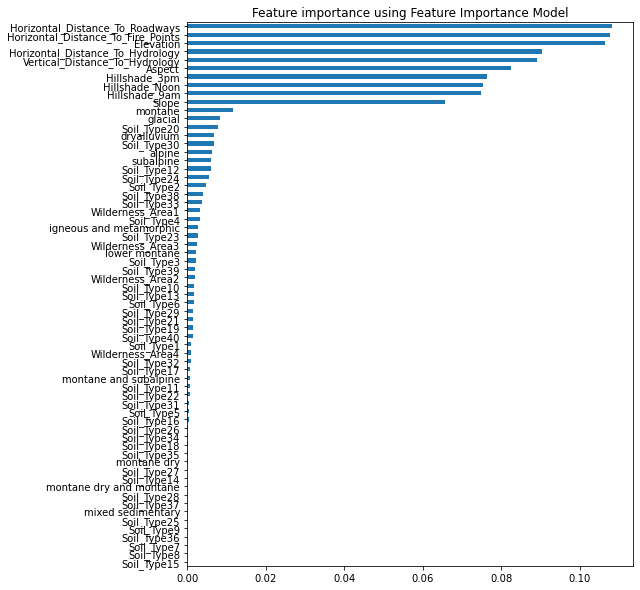

In [292]:
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X_datad, y_data)
coef = pd.Series(model.feature_importances_, index = X_datad.columns)
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Feature Importance Model")
plt.show()

### 4.2.3. Univariate Selection considerando variables originales

In [308]:
test = SelectKBest(score_func=f_classif, k=4)
fit = test.fit(data.iloc[:,:-1], y_data)
set_printoptions(precision=3)
scor_kbest = fit.scores_
features = fit.transform(data.iloc[:,:-1])

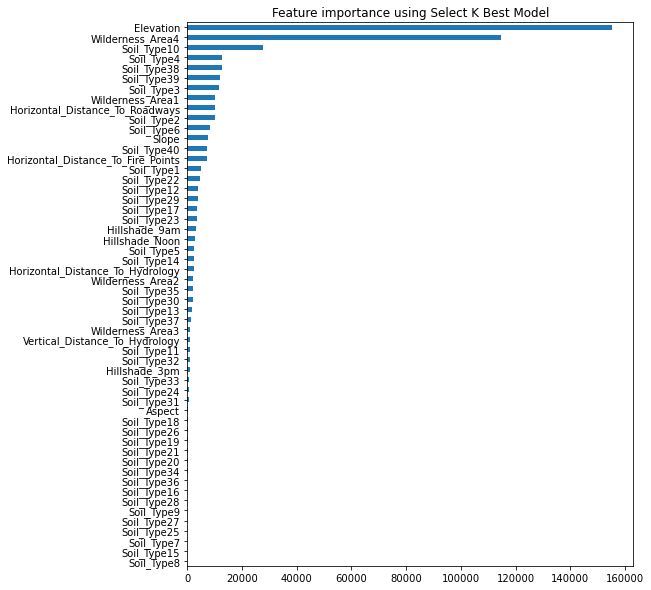

In [309]:
coef = pd.Series(scor_kbest, index =data.iloc[:,:-1].columns)
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Select K Best Model")
plt.show()

### 4.2.4. Feature Importance Model considerando variables originales

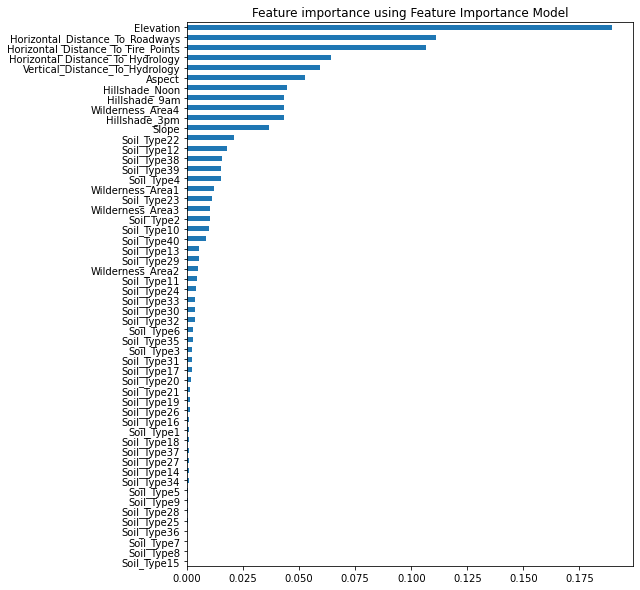

In [310]:
model = ExtraTreesClassifier(n_estimators=10)
model.fit(data.iloc[:,:-1], y_data)
coef = pd.Series(model.feature_importances_, index = data.iloc[:,:-1].columns)
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Feature Importance Model")
plt.show()

Por pruebas realizadas anteriormente el agregar información adicional al dataset original solo empeora la predicción del modelo, sea randomforest, xgboost, lightgbm, empeoran no pudiendo pasar accuracys mayor a 0.7. Esto se puede apreciar al realizar el análisis de variables, porque por lo visto la variable elevación es la variable predictora por excelencia en nuestro trabajo luego de analizar los gráficos, pero aún así al considerar todas las variables creadas este pasa a una novena y tercera posición respectivamente para los análisis revisados. Por este motivo solo se probarán las variables originales y se analizarán los modelos de randomforest y lightgbm en primera instancia. Se intentará seguir adicionalmente catboost adicionando un análisis de variables con la librería Shap para trabajos futuros.

# 5. Generación de modelos

Para generar los modelos de machine learning utilizando el dataset de Cover Type, se utilizará método de Random Forest y  LightGBM. Se analizará el modelo sin y con realizar modificaciones en sus hiperparámetros, además se evaluará realizar una separación del dataset de train/test siendo y no siendo estratificado, además de un test size de 0.7 y 0.5.

Para realizar este trabajo se utilizarán 3 funciones. La primera nos entregará un reporte completo de las métricas y además del cálculo del área bajo la curva ROC. La segunda función nos generará el gráfico del reporte obtenido. La tercera función generará el modelo dando la posibilidad de utilizar la función del gráfico para realizar el reporte completo utilizando los datos de entrenamiento y de testeo.

## 5.1. Definicion de funciones para modelos

In [41]:
#Función para obtener el AUC y el reporte de métricas
def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)


    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))


            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])


            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df


In [25]:
def complete_report(model ,X_test,y_test, titulo = "Sin título"):
    
    """ 
    La función genera un reporte para problemas de clasificación. Toma como entrada el modelo y los array
    que se quieren evaluar, en los parámetros son X_test e y_test, pero no significa que no puedan ser los 
    array de entrenamiento. Además se puede agregar un título para el gráfico de la matriz de confusión
    
    """
    #Se agrega el modelo y se realizan las predicciones
    model = model
    y_prob = model.predict_proba(X_test)
    y_pred = model.predict(X_test)

    #Se utiliza la función complete_report, mostrada en el chunk de código anterior
    complete_report =class_report(
                            y_true = y_test,
                            y_pred = y_pred,
                            y_score = y_prob)
    
    #Se crea el dataframe con los datos, para luego agregarlo a la gráfica del reporte como tabla
    report_df = pd.DataFrame(complete_report)
    report_df.reset_index(inplace = True)
    report_df = report_df.round(3)
    report_df["index"] = [1,2,3,4,5,6,7, "avg/total"]
    
    #Se calcula el accuracy
    accuracy_sc= accuracy_score(y_test, y_pred).round(3)

    #Se crea la matriz de confusión
    mat_rfhr = confusion_matrix(y_test, y_pred)


    #Se agrega el texto de los ejes
    x_axis_labels = ["{}".format(x) for x in range(1,8)] 
    y_axis_labels = ["{}".format(x) for x in range(1,8)] 
    #Se grafica la matriz de confusión
    sns.heatmap(mat_rfhr, square = True, annot = True, 
                fmt = "d", cbar = False, 
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels)
    #Se agrega el título del gráfico
    plt.title(titulo)
    #Se agrega el accuracy medio bajo la matriz de confusión y el Roc auc average
    plt.text(2.2, 8.5, "accuracy: {}".format(accuracy_sc), fontsize=13, color ="b")
    plt.text(1.6, 9.2, "Roc auc average: {}".format(report_df.iloc[7,6]), fontsize=13, color ="b")
    #Se agregan los mejores parámetros luego de realizar el grid search
    for j,i in enumerate(model.best_params_.keys()):
        plt.text(19.1,2+j/2.5, "{} : {}".format(i, model.best_params_[i]))
    #se agrega  una tabla que se formó con la función complete_report
    table = plt.table(cellText = report_df.values, colLabels = report_df.columns, loc = 14)
    #Ajustes estéticos
    table.set_fontsize(15)
    table.scale(1.7, 1.5)
    plt.subplots_adjust(right=0.8)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    

In [26]:
def funcion_modelo(modelo, titulo, X, y, cv = 2, parametros = {},
                   report_train = False, report_test = False, strat = None, tsize = 0.7):

    """
    Función para generar el modelo. Como parámetros de entrada está el modelo a utilizar, el título
    para luego agregarlo a los gráficos, cv para las validaciones cruzadas. Se  agrega parametros como
    el array de parámetros a calcular en el grid search, y se agrega la posibilidad de imprimir o no
    los gráficos de re porte
    
    """
    
    #Se crean los datos de test y entrenamiento
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= tsize, 
                                                        random_state=4986, stratify = strat)



    model = modelo
    model_grid = GridSearchCV(estimator = model,
                                   param_grid = parametros,
                                   cv = cv, verbose=5, n_jobs = 2)

    model_grid.fit(X_train, y_train)
    
    
    if report_train == True:
        print("########################################################################################")
        print("############################### Datos de Entrenamiento #################################")
        print("########################################################################################")
        complete_report(model = model_grid,X_test =X_train,y_test =y_train, titulo = "{} Train Data".format(titulo))
        print("\n\n")
    if report_test == True:
        print("########################################################################################")
        print("###############################     Datos de Testeo    #################################")
        print("########################################################################################")
        complete_report(model = model_grid, X_test = X_test, y_test = y_test, titulo = "{} Test Data".format(titulo))
    
    return model_grid

## 5.2. Random Forest

Para random forest se probará:

* Modelo 1: Data sin modificar, Hyperparámetros sin modificar, test size = 0.7, %_de_cada_clase = aleatorio
* Modelo 2: Data sin modificar, Hyperparámetros sin modificar, test size = 0.7, %_de_cada_clase = estratificado
* Modelo 3: Data sin modificar, Hyperparámetros sin modificar, test size = 0.5, %_de_cada_clase = estratificado

* Modelo 4: Data sin modificar, Hyperparámetros con modificar, test size = 0.7, %_de_cada_clase = aleatorio
* Modelo 5: Data sin modificar, Hyperparámetros con modificar, test size = 0.7, %_de_cada_clase = estratificado
* Modelo 6: Data sin modificar, Hyperparámetros con modificar, test size = 0.5, %_de_cada_clase = estratificado

### 5.2.1 Random Forest sin modificar y datos sin estratificar

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.6min finished


########################################################################################
############################### Datos de Entrenamiento #################################
########################################################################################


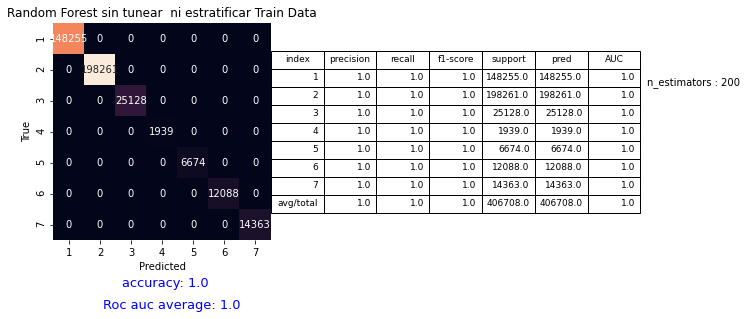




########################################################################################
###############################     Datos de Testeo    #################################
########################################################################################


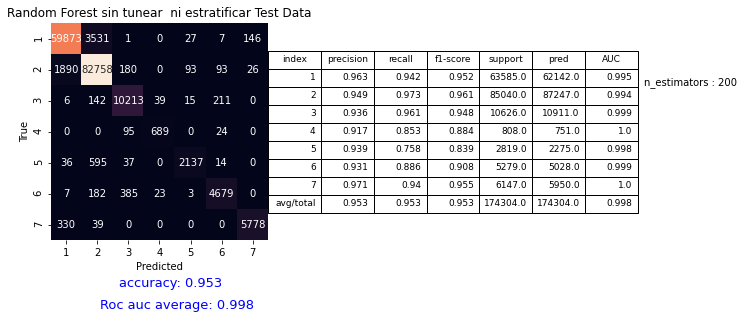

In [46]:
data = pd.read_csv("covtype2.csv")
X= data.iloc[:,:-1]
y= data.iloc[:,-1].map(lambda x: x-1)
titulo = "Random Forest sin tunear  ni estratificar"

parametros = {
    'n_estimators': [200],   
 }


rf_sintunear = funcion_modelo(RandomForestClassifier() ,titulo ,X,y,cv=2, 
                              parametros = parametros, report_train =  True, report_test = True)

### 5.2.2. Random Forest sin modificar y datos  estratificados

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.5min finished


########################################################################################
############################### Datos de Entrenamiento #################################
########################################################################################


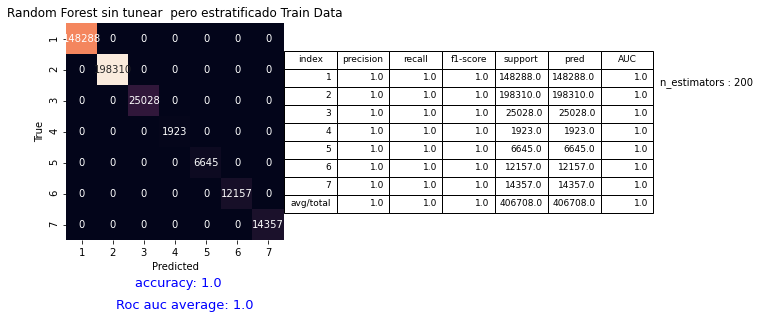




########################################################################################
###############################     Datos de Testeo    #################################
########################################################################################


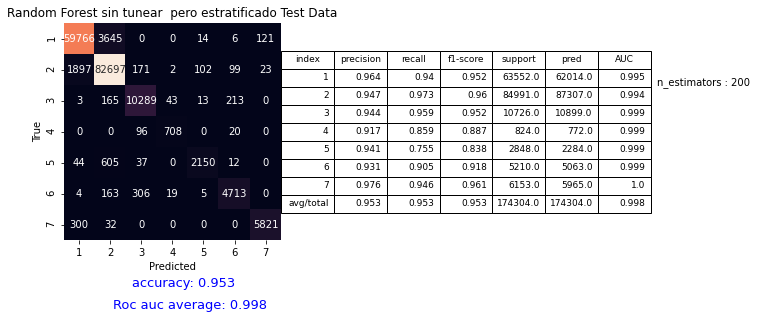

In [47]:
data = pd.read_csv("covtype2.csv")
X= data.iloc[:,:-1]
y= data.iloc[:,-1].map(lambda x: x-1)
titulo = "Random Forest sin tunear  pero estratificado"

parametros = {
    'n_estimators': [200],   
 }


rf_sintunear = funcion_modelo(RandomForestClassifier() ,titulo ,X,y,cv=2, 
                              parametros = parametros, report_train =  True, report_test = True,
                             strat = y)

### 5.2.3.  Random Forest sin modificar, estratificado y test_size = 0.5

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.1min finished


########################################################################################
############################### Datos de Entrenamiento #################################
########################################################################################


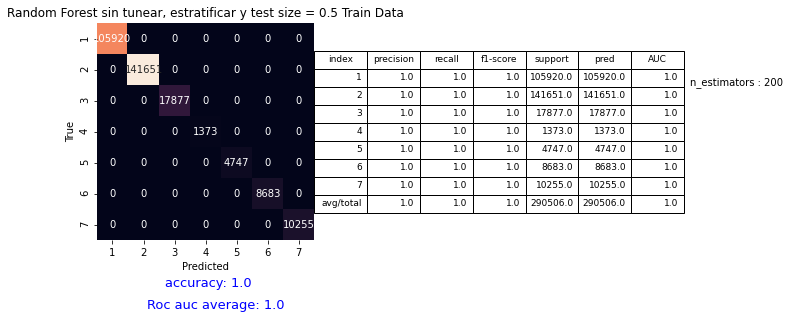




########################################################################################
###############################     Datos de Testeo    #################################
########################################################################################


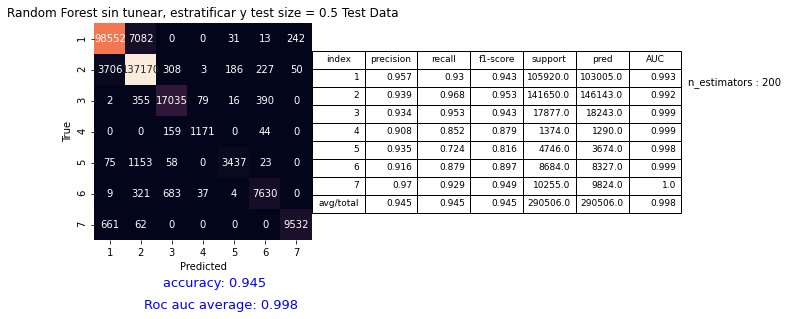

In [48]:
data = pd.read_csv("covtype2.csv")
X= data.iloc[:,:-1]
y= data.iloc[:,-1].map(lambda x: x-1)
titulo = "Random Forest sin tunear, estratificar y test size = 0.5"

parametros = {
    'n_estimators': [200],   
 }


rf_sintunear = funcion_modelo(RandomForestClassifier() ,titulo ,X,y,cv=2, 
                              parametros = parametros, report_train =  True, report_test = True,
                             strat = y, tsize = 0.5)

### 5.2.4. Random Forest con modificar pero no estratificado

Fitting 2 folds for each of 32 candidates, totalling 64 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 10.7min
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed: 48.8min finished


########################################################################################
############################### Datos de Entrenamiento #################################
########################################################################################


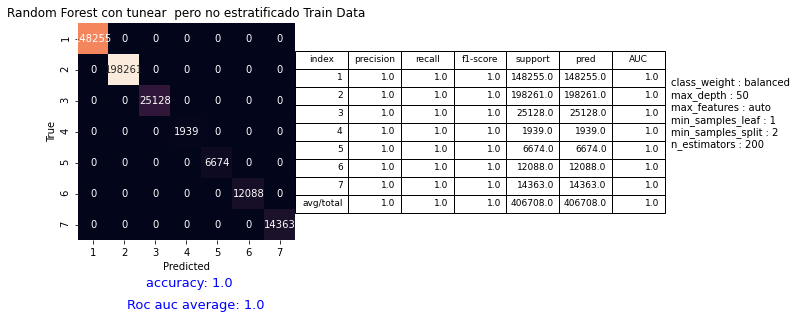




########################################################################################
###############################     Datos de Testeo    #################################
########################################################################################


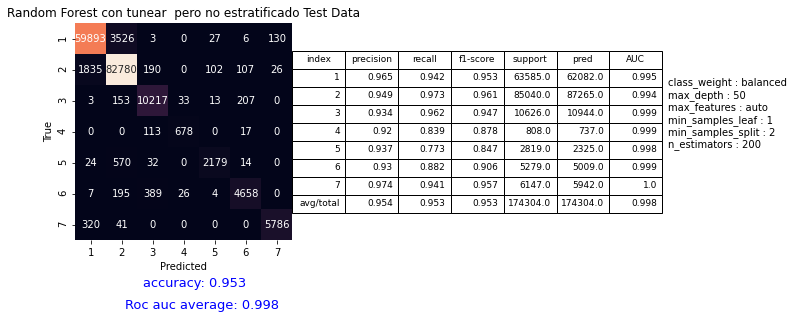

In [49]:
data = pd.read_csv("covtype2.csv")
X= data.iloc[:,:-1]
y= data.iloc[:,-1].map(lambda x: x-1)
titulo = "Random Forest con tunear  pero no estratificado"

parametros={'n_estimators' :[200],
            'max_depth': [None, 50],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2],
            'min_samples_split': [2, 3],
            'class_weight': [None, 'balanced']}

rf_sintunear = funcion_modelo(RandomForestClassifier() ,titulo ,X,y,cv=2, 
                              parametros = parametros, report_train =  True, report_test = True)

### 5.2.5. Random Forest con modificar y datos  estratificados

Fitting 2 folds for each of 32 candidates, totalling 64 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 10.6min
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed: 49.5min finished


########################################################################################
############################### Datos de Entrenamiento #################################
########################################################################################


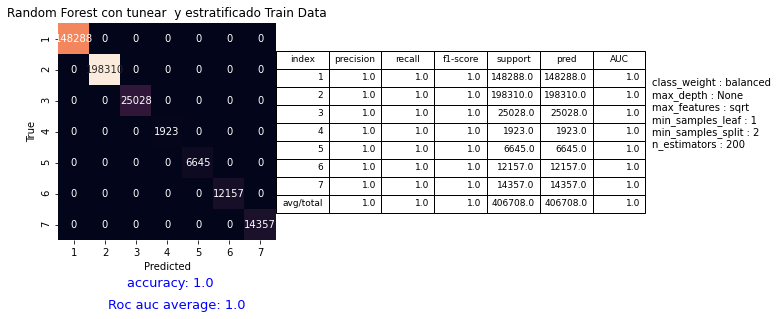




########################################################################################
###############################     Datos de Testeo    #################################
########################################################################################


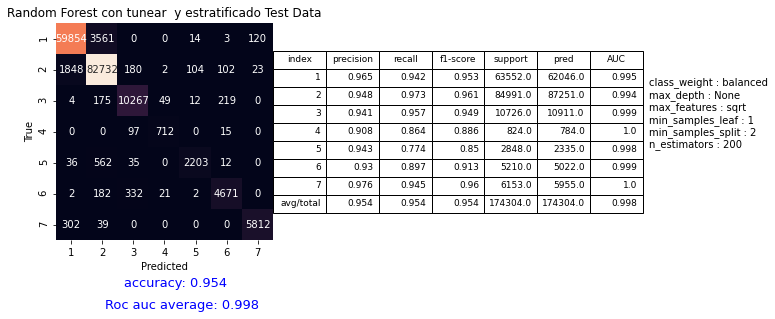

In [50]:
data = pd.read_csv("covtype2.csv")
X= data.iloc[:,:-1]
y= data.iloc[:,-1].map(lambda x: x-1)
titulo = "Random Forest con tunear  y estratificado"

parametros={'n_estimators' :[200],
            'max_depth': [None, 50],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2],
            'min_samples_split': [2, 3],
            'class_weight': [None, 'balanced']}


rf_sintunear = funcion_modelo(RandomForestClassifier() ,titulo ,X,y,cv=2, 
                              parametros = parametros, report_train =  True, report_test = True,
                             strat = y)

### 5.2.6. Random Forest con modificar, estratificado y test_size = 0.5

Fitting 2 folds for each of 32 candidates, totalling 64 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  7.9min
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed: 36.7min finished


########################################################################################
############################### Datos de Entrenamiento #################################
########################################################################################


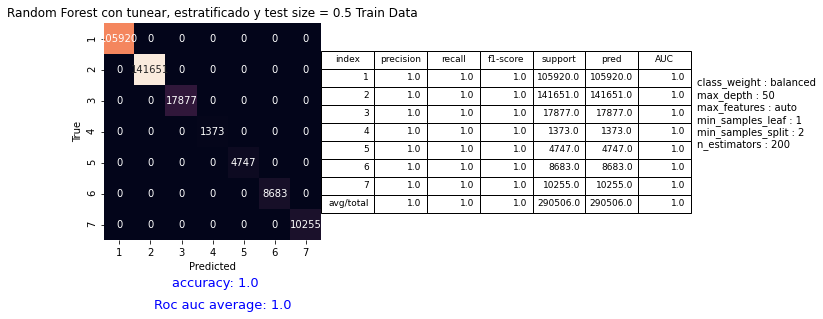




########################################################################################
###############################     Datos de Testeo    #################################
########################################################################################


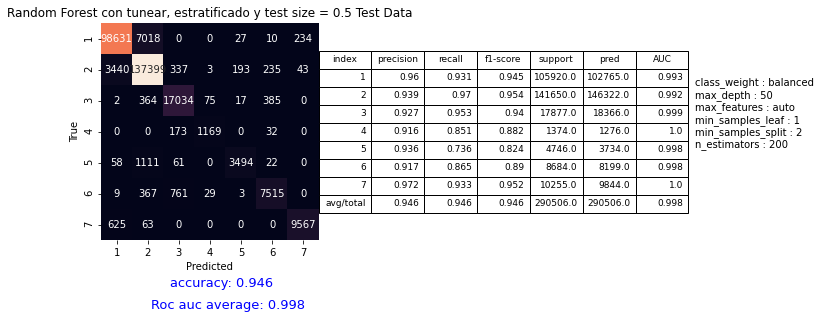

In [51]:
data = pd.read_csv("covtype2.csv")
X= data.iloc[:,:-1]
y= data.iloc[:,-1].map(lambda x: x-1)
titulo = "Random Forest con tunear, estratificado y test size = 0.5"

parametros={'n_estimators' :[200],
            'max_depth': [None, 50],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2],
            'min_samples_split': [2, 3],
            'class_weight': [None, 'balanced']}

rf_sintunear = funcion_modelo(RandomForestClassifier() ,titulo ,X,y,cv=2, 
                              parametros = parametros, report_train =  True, report_test = True,
                             strat = y, tsize = 0.5)

### 5.2.7. Resultados Random Forest

El resumen de los datos obtenido están en la siguiente tabla:

|Modelo| Data Modificada|Hip. Modificados|test size| % cada variable| Accuracy Train/Test | AUC Train/Test | Time (min) / Fits| 
|------|----------------|----------------|---------|----------------|---------------------|----------------|-----------|
|1     |  No            |    No          | 0.7     |  Aleatorio     |  1 / 0.953            |    1 / 0.998     | 1.6 /1  |
|2     |  No            |    No          | 0.7     |  Estratificado |  1 / 0.953            |    1 / 0.998     | 1.5 /1   |
|3     |  No            |    No          | 0.5     |  Estratificado |  1 / 0.945            |    1 / 0.998     | 1.1 /1   |
|4     |  No            |    Si          | 0.7     |  Aleatorio     |  1 / 0.953          |    1 / 0.998     | 48.8 /64   |
|5     |  No            |    Si          | 0.7     |  Estratificado |  1 / 0.954          |    1 / 0.998     | 49.5 /64   |
|6     |  No            |    Si          | 0.5     |  Estratificado |  1 / 0.946          |    1 / 0.998     | 36.7 /64   |

Al utilizar random forest se obtienen datos más que satisfactorios. Es un modelo que en general partió mostrando buenas métricas en sus predicciones, quizás con mucho sobre ajuste pero que de alguna menera no era perjudicial para el modelo, incluso tomando solo el 50% de la información se lograron altos accuracy y AUC. Lo que si es un modelo que toma tiempo en calcularse comparado con los modelos boosteados, como LightGBM que se verá a continuación.

## 5.3. LightGBM

Para LightGBM se probará:

* Modelo 1 : Data sin modificar, Hyperparámetros sin modificar, test size = 0.7, %_de_cada_clase = aleatorio
* Modelo 2: Data sin modificar, Hyperparámetros sin modificar, test size = 0.7, %_de_cada_clase = estratificado
* Modelo 3: Data sin modificar, Hyperparámetros sin modificar, test size = 0.5, %_de_cada_clase = estratificado

* Modelo 4: Data sin modificar, Hyperparámetros con modificar, test size = 0.7, %_de_cada_clase = aleatorio
* Por no ser tan significativo, se decidió proceder diréctamente al siguiente modelo análogo al 6to de Random Forest:
* Modelo 5: Data sin modificar, Hyperparámetros con modificar, test size = 0.5, %_de_cada_clase = estratificado

### 5.3.1 LightGBM sin tunear y sin estratificar

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   23.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   23.7s finished


########################################################################################
############################### Datos de Entrenamiento #################################
########################################################################################


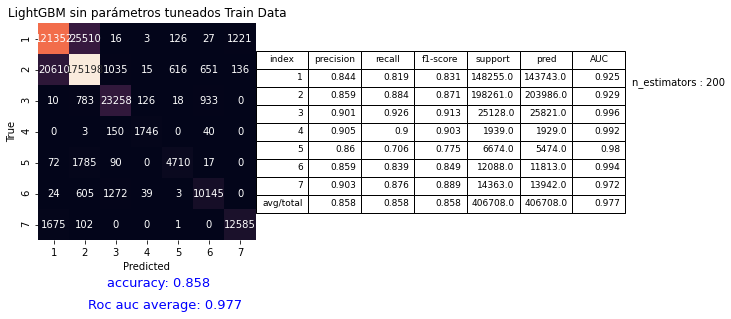




########################################################################################
###############################     Datos de Testeo    #################################
########################################################################################


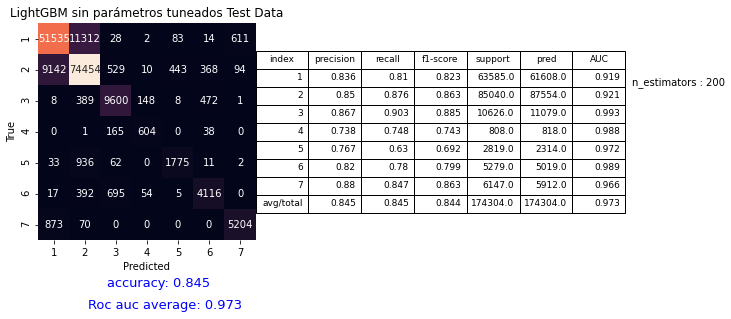

In [52]:
data = pd.read_csv("covtype2.csv")
X= data.iloc[:,:-1]
y= data.iloc[:,-1].map(lambda x: x-1)
titulo = "LightGBM sin parámetros tuneados"
parametros =  {'n_estimators' : [200]}


lightGBM_sintunear = funcion_modelo(lgb.LGBMClassifier(),titulo ,X,y,cv=2, parametros = parametros, report_train =  True, report_test = True)

### 5.3.2. LightGBM sin tunear y estratificado

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   16.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   16.5s finished


########################################################################################
############################### Datos de Entrenamiento #################################
########################################################################################


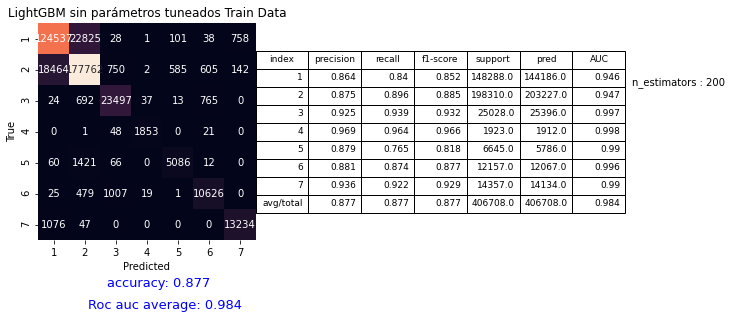




########################################################################################
###############################     Datos de Testeo    #################################
########################################################################################


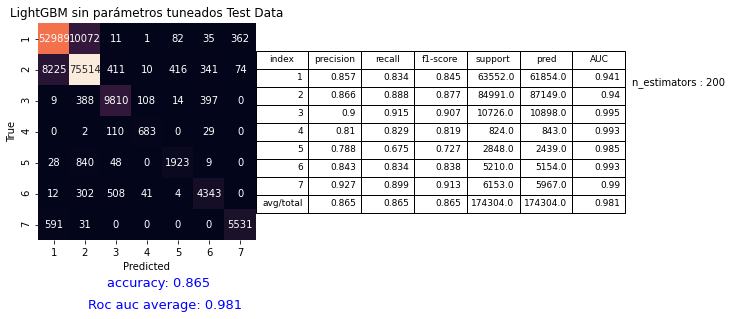

In [53]:
data = pd.read_csv("covtype2.csv")
X= data.iloc[:,:-1]
y= data.iloc[:,-1].map(lambda x: x-1)
titulo = "LightGBM sin parámetros tuneados"
parametros =  {'n_estimators' : [200]}


lightGBM_sintunear = funcion_modelo(lgb.LGBMClassifier(),titulo ,X,y,cv=2, parametros = parametros, report_train =  True, report_test = True, strat = y)

### 5.3.3. LightGBM sin tunear, estratificado y train_size = 0.5

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   11.6s finished


########################################################################################
############################### Datos de Entrenamiento #################################
########################################################################################


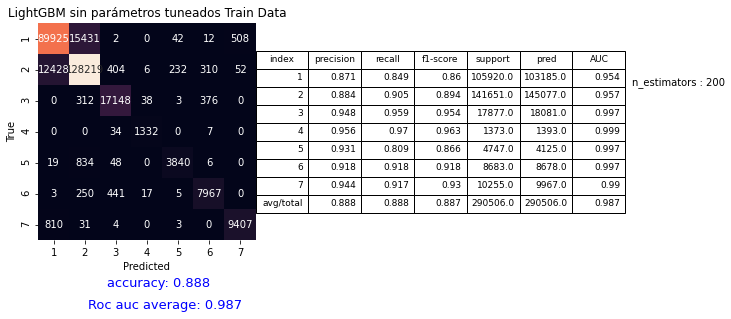




########################################################################################
###############################     Datos de Testeo    #################################
########################################################################################


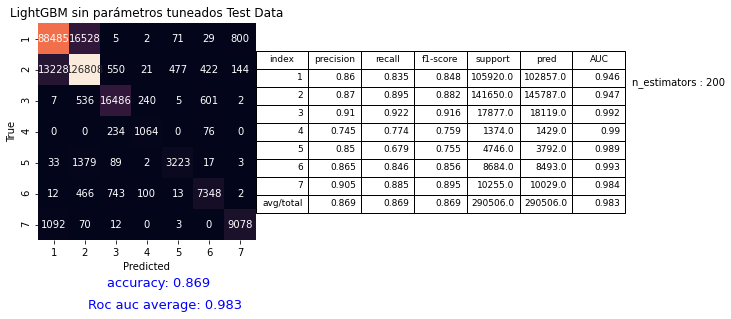

In [54]:
data = pd.read_csv("covtype2.csv")
X= data.iloc[:,:-1]
y= data.iloc[:,-1].map(lambda x: x-1)
titulo = "LightGBM sin parámetros tuneados"
parametros =  {'n_estimators' : [200]}


lightGBM_sintunear = funcion_modelo(lgb.LGBMClassifier(),titulo ,X,y,cv=2, parametros = parametros, report_train =  True, report_test = True, strat = y, tsize = 0.5)

### 5.3.4. LightGBM con tunear sin estratificar

Fitting 2 folds for each of 768 candidates, totalling 1536 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  8.9min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 35.9min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 80.0min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed: 138.5min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 215.9min
[Parallel(n_jobs=2)]: Done 644 tasks      | elapsed: 305.5min
[Parallel(n_jobs=2)]: Done 878 tasks      | elapsed: 416.9min
[Parallel(n_jobs=2)]: Done 1148 tasks      | elapsed: 540.6min
[Parallel(n_jobs=2)]: Done 1454 tasks      | elapsed: 691.3min
[Parallel(n_jobs=2)]: Done 1536 out of 1536 | elapsed: 727.9min finished


########################################################################################
############################### Datos de Entrenamiento #################################
########################################################################################


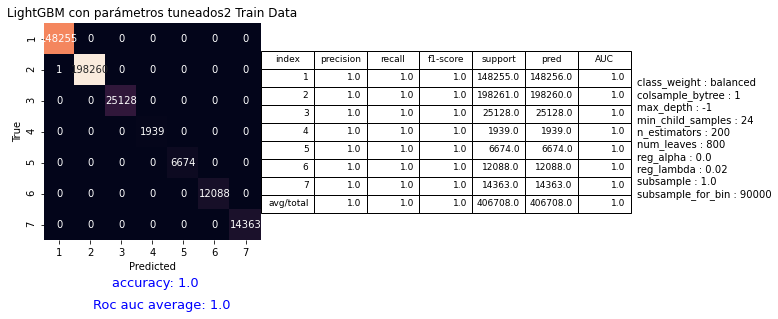




########################################################################################
###############################     Datos de Testeo    #################################
########################################################################################


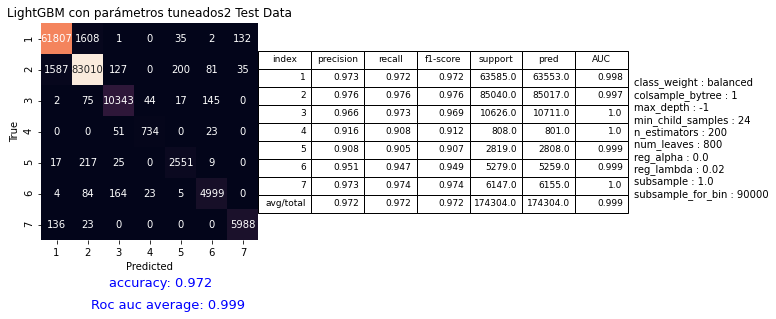

In [55]:
data = pd.read_csv("covtype2.csv")
X= data.iloc[:,:-1]
y= data.iloc[:,-1].map(lambda x: x-1)
titulo = "LightGBM con parámetros tuneados2"
parametros = {
    'n_estimators': [200],
    'num_leaves': [800,300],
    'max_depth': [-1,50],
    'subsample_for_bin': [110000,100000,90000],
    'class_weight' : [None, 'balanced'],
    'reg_alpha' : [0.0, 0.2],
    'reg_lambda' : [0.02, 0.2],
    'min_child_samples' : [24, 20],
    'subsample' : [1.0, 0.5],
    'colsample_bytree' : [1, 0.5]    
 }


lightGBM_tuneado2 = funcion_modelo(lgb.LGBMClassifier(),titulo ,X,y,cv=2, parametros = parametros, report_train =  True, report_test = True)

### 5.3.5. LightGBM con tunear, estratificado y train_size = 0.5

Fitting 2 folds for each of 768 candidates, totalling 1536 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  6.1min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 25.0min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 55.4min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed: 94.1min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 150.3min
[Parallel(n_jobs=2)]: Done 644 tasks      | elapsed: 216.9min
[Parallel(n_jobs=2)]: Done 878 tasks      | elapsed: 292.5min
[Parallel(n_jobs=2)]: Done 1148 tasks      | elapsed: 387.5min
[Parallel(n_jobs=2)]: Done 1454 tasks      | elapsed: 498.7min
[Parallel(n_jobs=2)]: Done 1536 out of 1536 | elapsed: 526.8min finished


########################################################################################
############################### Datos de Entrenamiento #################################
########################################################################################


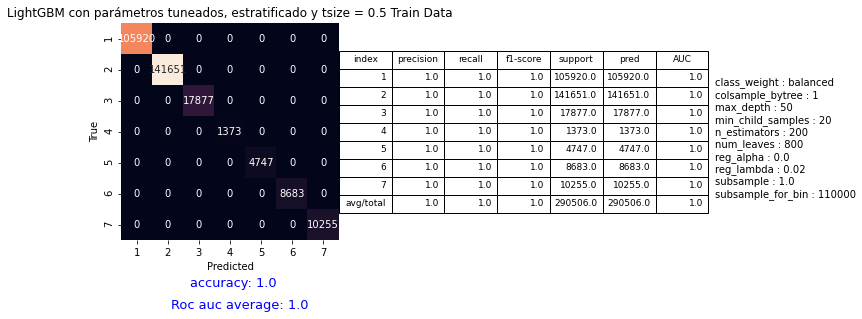




########################################################################################
###############################     Datos de Testeo    #################################
########################################################################################


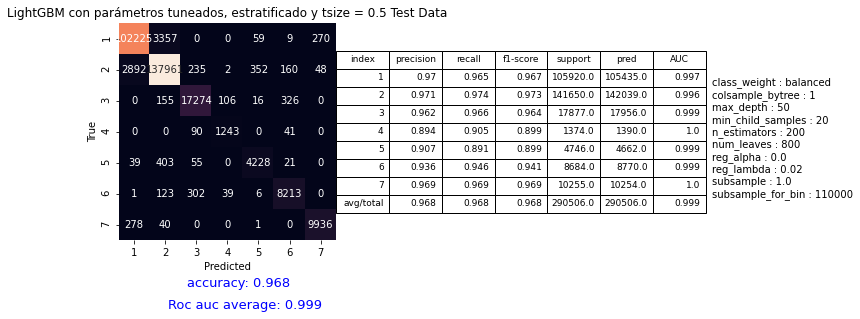

In [56]:
data = pd.read_csv("covtype2.csv")
X= data.iloc[:,:-1]
y= data.iloc[:,-1].map(lambda x: x-1)
titulo = "LightGBM con parámetros tuneados, estratificado y tsize = 0.5"
parametros = {
    'n_estimators': [200],
    'num_leaves': [800,300],
    'max_depth': [-1,50],
    'subsample_for_bin': [110000,100000,90000],
    'class_weight' : [None, 'balanced'],
    'reg_alpha' : [0.0, 0.2],
    'reg_lambda' : [0.02, 0.2],
    'min_child_samples' : [24, 20],
    'subsample' : [1.0, 0.5],
    'colsample_bytree' : [1, 0.5]    
 }


lightGBM_tuneado2 = funcion_modelo(lgb.LGBMClassifier(),titulo ,X,y,cv=2, parametros = parametros, report_train =  True, report_test = True, strat = y, tsize = 0.5)

### 5.3.6. Resultados LightGBM

Los resultados de LightGBM se resumen en la siguiente tabla:

|Modelo| Data Modificada|Hip. Modificados|test size| % cada variable| Accuracy Train/Test | AUC Train/Test | Time (min)/Fits|
|------|----------------|----------------|---------|----------------|---------------------|----------------|-----------|
|1     |  No            |    No          | 0.7     |  Aleatorio     |  0.858 / 0.845    |    0.977 / 0.973   | 0.394 /1   |
|2     |  No            |    No          | 0.7     |  Estratificado |  0.877 / 0.865    |    0.865 / 0.981   | 0.275 /1   |
|3     |  No            |    No          | 0.5     |  Estratificado |  0.888 / 0.0.869   |    0.987/ 0.983   | 0.193 /1  |
|4     |  No            |    Si          | 0.7     |  Aleatorio     |  1 / 0.972     |    1 / 0.999   | 727.9/1536    |
|5     |  No            |    Si          | 0.5     |  Estratificado |  1 / 0.968     |    1 / 0.999   | 526.8 /1536    |

LightGBM como modelo primero destaca por su velocidad, milésimas de segundo para realizar cada iteración. No muestra métricas tan altas hasta que se modifican sus hiperparámetros, llegando a valores de accuracy para datos de testeo de 0.972  y de AUC de 0.999 aunque, nuevamente, pareciera que los datos están sobre ajustados. Además se generó un modelo casi igual de bueno cuando se consideraba solo la mitad de la información para el entrenamiento.

## 5.4. Comparativa de modelos

Random Forest

|Modelo| Data Modificada|Hip. Modificados|test size| % cada variable| Accuracy Train/Test | AUC Train/Test | Time (min) / Fits| 
|------|----------------|----------------|---------|----------------|---------------------|----------------|-----------|
|1     |  No            |    No          | 0.7     |  Aleatorio     |  1 / 0.953            |    1 / 0.998     | 1.6 /1  |
|2     |  No            |    No          | 0.7     |  Estratificado |  1 / 0.953            |    1 / 0.998     | 1.5 /1   |
|3     |  No            |    No          | 0.5     |  Estratificado |  1 / 0.945            |    1 / 0.998     | 1.1 /1   |
|4     |  No            |    Si          | 0.7     |  Aleatorio     |  1 / 0.953          |    1 / 0.998     | 48.8 /64   |
|5     |  No            |    Si          | 0.7     |  Estratificado |  1 / 0.954          |    1 / 0.998     | 49.5 /64   |
|6     |  No            |    Si          | 0.5     |  Estratificado |  1 / 0.946          |    1 / 0.998     | 36.7 /64   |

LightGBM

|Modelo| Data Modificada|Hip. Modificados|test size| % cada variable| Accuracy Train/Test | AUC Train/Test | Time (min)/Fits|
|------|----------------|----------------|---------|----------------|---------------------|----------------|-----------|
|1     |  No            |    No          | 0.7     |  Aleatorio     |  0.858 / 0.845    |    0.977 / 0.973   | 0.394 /1   |
|2     |  No            |    No          | 0.7     |  Estratificado |  0.877 / 0.984    |    0.865 / 0.981   | 0.275 /1   |
|3     |  No            |    No          | 0.5     |  Estratificado |  0.888 / 0.0.869   |    0.987/ 0.983   | 0.193 /1  |
|4     |  No            |    Si          | 0.7     |  Aleatorio     |  1 / 0.972     |    1 / 0.999   | 727.9/1536    |
|5     |  No            |    Si          | 0.5     |  Estratificado |  1 / 0.968     |    1 / 0.999   | 526.8 /1536    |

Si realizamos la comparativa de modelos se pudo lograr aumentar tanto el accuracy como el AUC para los datos de entrenamiento utilizando el método LightGBM sobre Random Forest. Además, la velocidad de cálculo fue mucho más rápido utilizando el método LightGBM, solo demorando fracciones de segundo para realizar los entrenamientos al modificar los hiperparámetros. Finalmente se confirma que el set de datos utilizado es el correcto y que utilizando estos modelos no hay que preocuparse del desbalanceo, ya que utilizando LightGBM se logra generar modelos rápidamente y con métricas de accuracy y AUC altas.

# 6. Conclusión

Se puede concluir que LightGBM es en su mayoría mejor que Random Forest. Con el modelo LightGBM se logran mejores métricas de accuracy: 0.972 para LightGBM vs 0.954 para Random Forest y valores igualados de AUC, aproximadamente 1. Si se comparan las velocidades, Random Forest demoraba más de 0.5 segundos por iteración, mientras que LightGBM demoraba menos de 0.5 segundos por iteración.  Finalmente habría que analizar el sobre ajuste de los modelos debido que al considerar una alta profundidad en la confección de los modelos, además de una gran cantidad de hojas para ir separando las decisiones se logró una predicción perfecta en los datos de entrenamiento, aun así, quizás no sea un tema importanta debido a los altos valores para el set de testeo aún tomando el 50% del dataset para entrenamiento.